In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from sklearn.preprocessing import LabelEncoder
from scipy.stats import kurtosis, skew
# from statsmodels.formula.api import ols
# from scipy.stats import ttest_ind, shapiro, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_columns", 100)

# Lectura y transformación de datos

In [2]:
datos = pd.read_excel("datos/Export.xlsx", skiprows=7)
datos.sample(5)

Num   Country                           Company  \
5067  5068  Colombia                   Monomerados Sas   
9620  9621  Colombia                     Intersare S A   
8415  8416  Colombia                    Oxitrans S A S   
1555  1556  Colombia  Pharmalab Phl Laboratorios S A S   
2062  2063  Colombia                   Don Maiz S.A.S.   

      Total operating revenue Operational Status         City  \
5067                 19449.29        Operational  Bogota D.C.   
9620                  8490.12        Operational  Bogota D.C.   
8415                 10129.38        Operational  Bogota D.C.   
1555                 87124.91        Operational  Bogota D.C.   
2062                 60880.19        Operational  Bogota D.C.   

                                                                           Business Description/Products  \
5067                                                                                                 NaN   
9620  The company Intersare S.A. is primarily engaged in amusement, gambling, and recreation industries.   
8415                           The company Oxitrans S.A.S. is primarily engaged in truck transportation.   
1555                                                                                                 NaN   
2062                                                              Elaboracion de productos alimenticios.   

                                                        Industry (NAICS)  \
5067  Lumber and Other Construction Materials Merchant Wholesalers(4233)   
9620                                           Gambling Industries(7132)   
8415                                      General Freight Trucking(4841)   
1555            Drugs and Druggists' Sundries Merchant Wholesalers(4242)   
2062                           Bakeries and Tortilla Manufacturing(3118)   

                                                 Main Activities (NAICS)  \
5067  Lumber and Other Construction Materials Merchant Wholesalers(4233)   
9620                                           Gambling Industries(7132)   
8415                                      General Freight Trucking(4841)   
1555            Drugs and Druggists' Sundries Merchant Wholesalers(4242)   
2062                           Bakeries and Tortilla Manufacturing(3118)   

     Secondary Activities (NAICS)  \
5067                          NaN   
9620                          NaN   
8415                          NaN   
1555                          NaN   
2062                          NaN   

                                                                             Industry (EMIS Industries)  \
5067                                                                                      Wholesale(25)   
9620                                                  Tourism and leisure(11); Leisure facilities(11.3)   
8415  Transportation and logistics(14); Road transportation(14.4); Truck freight transportation(14.4.2)   
1555                                                                                      Wholesale(25)   
2062                       Food and beverage production(2); Food production(2.1); Baked products(2.1.2)   

                                                                      Main Activities (EMIS Industries)  \
5067                                                                                      Wholesale(25)   
9620                                                  Tourism and leisure(11); Leisure facilities(11.3)   
8415  Transportation and logistics(14); Road transportation(14.4); Truck freight transportation(14.4.2)   
1555                                                                                      Wholesale(25)   
2062                       Food and beverage production(2); Food production(2.1); Baked products(2.1.2)   

     Secondary Activities (EMIS Industries)  \
5067                                    NaN   
9620                                    NaN   
8415                                    NaN   
1555   

In [3]:
datos = datos[0:10000]
datos = datos.loc[
    :,
    (
        "Company",
        "Cash and Cash Equivalents",    
        "Export",
        "Import",
        "Industry (NAICS)",
        "Long term Debt",
        "Net Sales Revenue Trend (%)",
        "Number of Employees",
        "Operating Profit Trend (%)",
        "Property, plant and equipment",
        "Return on Assets (ROA) (%)",
        "Return on Equity (ROE) (%)",
        "Quick Ratio (x)",
        "Short Term Debt",      
        "Total operating revenue",
    )
]


In [4]:
datos.sample(3)

Company  Cash and Cash Equivalents  \
7191            Ico Vallas S.A.S                        NaN   
8357  Car Center de Colombia S A                     148.48   
7564     Aromas & Procesos S.A.S                        NaN   

                        Export  \
7191                             
8357                             
7564  PA (62.41%), DO (37.59%)   

                                                                                                   Import  \
7191                                                                                                        
8357  UK (0.25%), ID (1.35%), CN (8.68%), TW (1.75%), IN (0.01%), MX (2.91%), VN (0.42%), US (83.39%),...   
7564  UK (0.77%), ID (1.23%), DE (5.32%), CN (36.46%), IN (5.07%), CH (14.88%), MX (0.8%), BR (10.69%)...   

                                                                                         Industry (NAICS)  \
7191                                                                          Advertising Agencies(54181)   
8357  New Car Dealers(44111); Motor Vehicle and Motor Vehicle Parts and Supplies Merchant Wholesalers(...   
7564                                      All Other Chemical Product and Preparation Manufacturing(32599)   

      Long term Debt  Net Sales Revenue Trend (%) Number of Employees  \
7191            0.00                        32.75           10 (2024)   
8357            0.00                       -17.29           48 (2024)   
7564            0.00                        24.73           33 (2024)   

      Operating Profit Trend (%)  Property, plant and equipment  \
7191                      -56.52                           0.00   
8357                      -89.81                         134.16   
7564                       48.89                           0.00   

      Return on Assets (ROA) (%)  Return on Equity (ROE) (%)  Quick Ratio (x)  \
7191                       -1.97                       -6.96             1.01   
8357                       -0.23                       -0.87             0.51   
7564                       12.17                       25.85             2.09   

      Short Term Debt  Total operating revenue  
7191             0.00                 12428.31  
8357             0.00                 10210.92  
7564             0.00                 11621.42

In [5]:
datos.to_csv("datos/Pruebas.csv")

In [6]:
# Función para extraer los países y porcentajes con expresiones regulares
def extract_countries_values_regex(column):
    country_dict = {}
    for row in column.dropna():
        # Buscar todas las ocurrencias del patrón 'PAIS (Porcentaje%)' o 'PAIS'
        matches = re.findall(r'([A-Za-z\s]+)(?:\s*\(([\d.]+)%\))?', row)
        for country, percentage in matches:
            country = country.strip()
            if percentage:
                percentage = float(percentage)
            else:
                percentage = 0.0  # Si no hay porcentaje, asignamos 0.0
            country_dict[country] = country_dict.get(country, 0) + percentage
    return country_dict

# Función para extraer los porcentajes de un item
def extract_percentage_from_item(item):
    try:
        # Verificar si el item contiene un porcentaje, de lo contrario devolver 0.0
        if '(' in item and ')' in item:
            return float(item.split('(')[1].replace('%', '').replace(')', '').strip())
        else:
            return 0.0
    except (IndexError, ValueError):
        return 0.0  # Manejo de errores si no es posible convertir el porcentaje

In [7]:
# Empleados
datos['Employees'] = datos['Number of Employees'].str.extract(r'([\d,]+)\s\(\d{4}\)')
datos['Employees'] = datos['Employees'].str.replace(',', '').replace('', np.nan).astype(float)

# Extraer países y sus porcentajes de las columnas de Import y Export
import_data_full = extract_countries_values_regex(datos['Import'])
export_data_full = extract_countries_values_regex(datos['Export'])

# Combinar importaciones y exportaciones por país
combined_data_full = {}
for country in set(import_data_full.keys()).union(export_data_full.keys()):
    combined_data_full[country] = import_data_full.get(country, 0) + export_data_full.get(country, 0)

# Obtener el top 10 de países con mayor participación
top_10_countries_full = sorted(combined_data_full.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_countries_full = [country for country, value in top_10_countries_full]

# Generar nuevas columnas para el top 10 de países
for country in top_10_countries_full:
    datos[f'Export_{country}'] = datos['Export']. \
        apply(
            lambda x: extract_percentage_from_item(
                [item for item in x.split(',') if country in item][0]
            ) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0
        )
    datos[f'Import_{country}'] = datos['Import']. \
        apply(
            lambda x: extract_percentage_from_item(
                [item for item in x.split(',') if country in item][0]
            ) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0
        )

# Contar cuántos países están involucrados en importaciones y exportaciones
num_importing_countries_full = datos['Import'].apply(
    lambda x: len(re.findall(r'[A-Za-z\s]+', x)) if isinstance(x, str) else 0).sum()
num_exporting_countries_full = datos['Export'].apply(
    lambda x: len(re.findall(r'[A-Za-z\s]+', x)) if isinstance(x, str) else 0).sum()

# Mostrar el conteo de países
print(f"Total de países que importan: {num_importing_countries_full}")
print(f"Total de países que exportan: {num_exporting_countries_full}")

Total de países que importan: 34153
Total de países que exportan: 15900


In [8]:
datos.sample(3)

Company  \
1650                                                                          Inversiones Panoramia S.A.S   
2654  Fundacion Javeriana De Servicios Medicos Odontologicos Interuniversitarios "Carlos Marquez Ville...   
8364                                                                               Construcciones Sem Sas   

      Cash and Cash Equivalents Export Import  \
1650                   18908.18                 
2654                     339.65                 
8364                        NaN                 

                              Industry (NAICS)  Long term Debt  \
1650  Residential Building Construction(23611)            0.00   
2654                    Social Assistance(624)            0.00   
8364  Residential Building Construction(23611)            0.00   

      Net Sales Revenue Trend (%) Number of Employees  \
1650                         8.37            7 (2024)   
2654                        12.83                 NaN   
8364                          NaN          352 (2022)   

      Operating Profit Trend (%)  Property, plant and equipment  \
1650                     -292.98                          49.20   
2654                       70.61                       21407.89   
8364                         NaN                           0.00   

      Return on Assets (ROA) (%)  Return on Equity (ROE) (%)  Quick Ratio (x)  \
1650                        1.35                        3.78             0.60   
2654                        2.41                        7.52             0.33   
8364                       14.44                       22.38             1.11   

      Short Term Debt  Total operating revenue  Employees  Export_CN  \
1650            52.92                 81265.89       7.00       0.00   
2654         13500.57                 44936.03        NaN       0.00   
8364             0.00                 10203.09     352.00       0.00   

      Import_CN  Export_US  Import_US  Export_EC  Import_EC  Export_MX  \
1650       0.00       0.00       0.00       0.00       0.00       0.00   
2654       0.00       0.00       0.00       0.00       0.00       0.00   
8364       0.00       0.00       0.00       0.00       0.00       0.00   

      Import_MX  Export_ES  Import_ES  Export_DE  Import_DE  Export_BR  \
1650       0.00       0.00       0.00       0.00       0.00       0.00   
2654       0.00       0.00       0.00       0.00       0.00       0.00   
8364       0.00       0.00       0.00       0.00       0.00       0.00   

      Import_BR  Export_PE  Import_PE  Export_IT  Import_IT  Export_PA  \
1650       0.00       0.00       0.00       0.00       0.00       0.00   
2654       0.00       0.00       0.00       0.00       0.00       0.00   
8364       0.00       0.00       0.00       0.00       0.00       0.00   

      Import_PA  
1650       0.00  
2654       0.00  
8364       0.00

In [9]:
datos.columns

Index(['Company', 'Cash and Cash Equivalents', 'Export', 'Import',
       'Industry (NAICS)', 'Long term Debt', 'Net Sales Revenue Trend (%)',
       'Number of Employees', 'Operating Profit Trend (%)',
       'Property, plant and equipment', 'Return on Assets (ROA) (%)',
       'Return on Equity (ROE) (%)', 'Quick Ratio (x)', 'Short Term Debt',
       'Total operating revenue', 'Employees', 'Export_CN', 'Import_CN',
       'Export_US', 'Import_US', 'Export_EC', 'Import_EC', 'Export_MX',
       'Import_MX', 'Export_ES', 'Import_ES', 'Export_DE', 'Import_DE',
       'Export_BR', 'Import_BR', 'Export_PE', 'Import_PE', 'Export_IT',
       'Import_IT', 'Export_PA', 'Import_PA'],
      dtype='object')

In [10]:
datos['First_Sector'] = datos['Industry (NAICS)'].str.split(';').str[0]

# Mostrar las primeras filas con la nueva columna
datos[['Company', 'Industry (NAICS)', 'First_Sector']].head()

Company  \
0             Ecopetrol S.A.   
1   Organizacion Terpel S.A.   
2                   D1 S A S   
3  Enel Colombia S.A. E.S.P.   
4               Drummond Ltd   

                                                                                      Industry (NAICS)  \
0                                     Natural Gas Extraction(21113); Crude Petroleum Extraction(21112)   
1  Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472...   
2                                                                                 Grocery Stores(4451)   
3                                                                     Electric Power Generation(22111)   
4                            Support Activities for Oil and Gas Operations(213112); Coal Mining(21211)   

                                                                                        First_Sector  
0                                                                      Natural Gas Extraction(21113)  
1  Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472)  
2                                                                               Grocery Stores(4451)  
3                                                                   Electric Power Generation(22111)  
4                                              Support Activities for Oil and Gas Operations(213112)

# Análisis de las columnas de interes

In [11]:
### Funciones

# Histogramas
def plot_histogram(
        data,
        column,
        bins=20,
        color='blue',
        edgecolor='black',
        figsize=(8, 5)
    ):
    """
    Función para graficar un histograma de una columna específica de un DataFrame.
    """
    plt.figure(figsize=figsize)
    plt.hist(data[column], bins=bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

def plot_boxplot(data, column, color='lightblue', figsize=(8, 5)):
    """
    Función para graficar un boxplot de una columna específica de un DataFrame.
    """
    plt.figure(figsize=figsize)
    sns.boxplot(x=data[column], color=color)
    plt.title(f'Boxplot de {column}')
    plt.show()

def filter_outliers_iqr_and_plot(
        data,
        column,
        factor_lower=1.5,
        factor_upper=3,
        bins=20,
        color='blue',
        edgecolor='black',
        figsize=(8, 5)
    ):
    """
    Función para filtrar outliers utilizando el método del IQR (rango intercuartílico).
    Graficar sin outliers, barras y cajas y bigotes
    """
    # Calcular el IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    lower_bound = Q1 - factor_lower * IQR
    upper_bound = Q3 + factor_upper * IQR

    # Filtrar los datos eliminando los outliers
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    # Histograma
    plt.figure(figsize=figsize)
    plt.hist(filtered_data[column], bins=bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribución de {column} (Sin outliers)')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

    # Boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(x=filtered_data[column], color=color)
    plt.title(f'Boxplot de {column} (Sin outliers)')
    plt.show()
    
    # Eliminar valores nulos en la columna 'Property, plant and equipment' para poder calcular las estadísticas
    datos_clean = filtered_data[column].dropna()

    # Calcular la kurtosis y la asimetría nuevamente después de limpiar los datos
    kurt = kurtosis(datos_clean, fisher=False)  # Fisher=False para la definición clásica
    skw = skew(datos_clean)

    # Manejar valores NaN
    kurt = int(kurt) if not np.isnan(kurt) else kurt
    skw = int(skw) if not np.isnan(skw) else skw

    return filtered_data, kurt, skw


## Property, plany and equipment

In [12]:
variable = "Property, plant and equipment"
prop_plant_equip = datos[variable]
prop_plant_equip.describe()

count       9986.00
mean       38706.78
std      1028316.04
min         -287.55
25%            0.00
50%          111.28
75%         3589.09
max     95171301.60
Name: Property, plant and equipment, dtype: float64

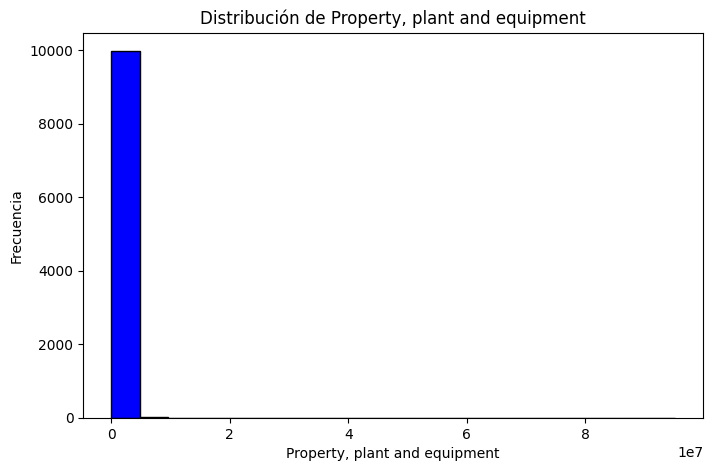

In [13]:
plot_histogram(datos, variable)

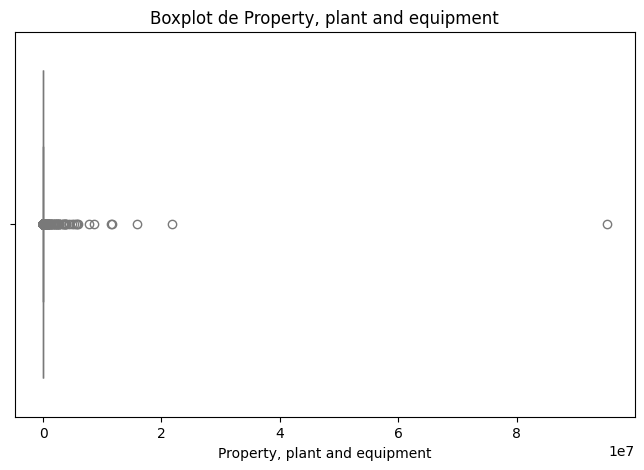

In [14]:
plot_boxplot(datos, variable)

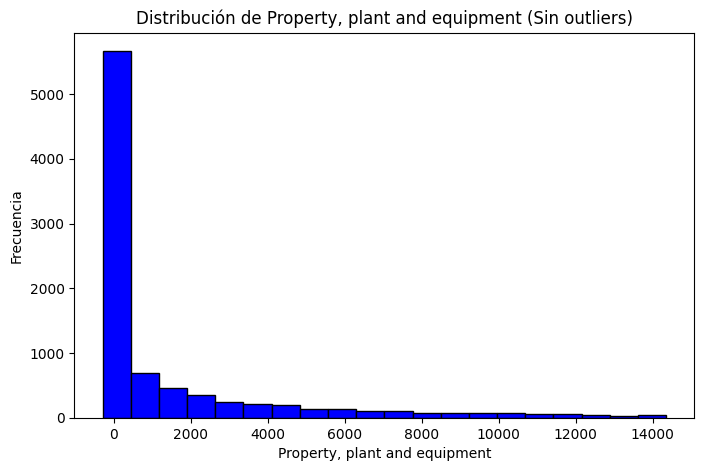

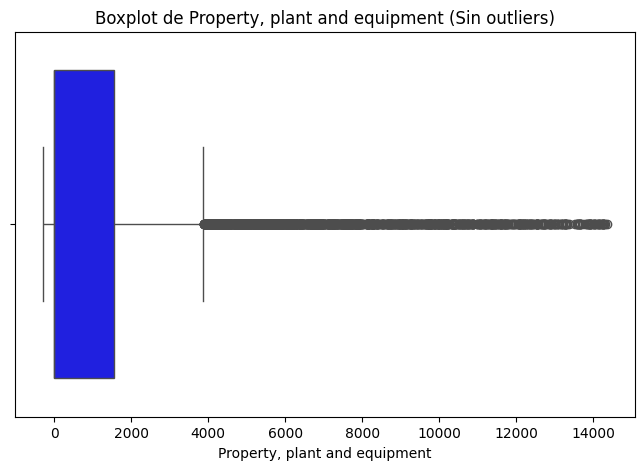

La curtosis para la variable Property, plant and equipment es: 8
El sesgo para la variable Property, plant and equipment es: 2


In [15]:
df_propiedad, curtosis_propiedad, sesgo_propiedad = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_propiedad}")
print(f"El sesgo para la variable {variable} es: {sesgo_propiedad}")

## Cash and Cash Equivalents

In [16]:
variable = "Cash and Cash Equivalents"
dinero_equivalentes = datos[variable]
dinero_equivalentes.describe()

count       5683.00
mean       26014.15
std       463498.28
min            0.00
25%          506.98
50%         1788.07
75%         6158.08
max     20781776.91
Name: Cash and Cash Equivalents, dtype: float64

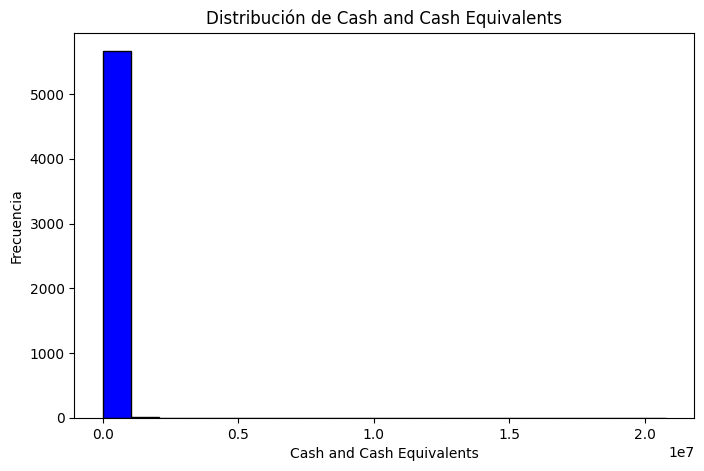

In [17]:
plot_histogram(datos, variable)

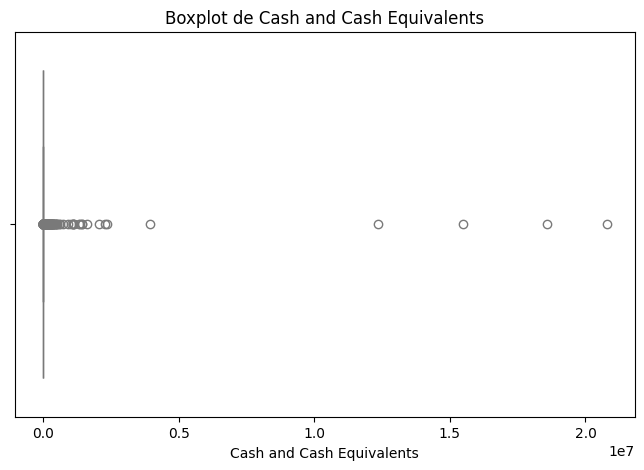

In [18]:
plot_boxplot(datos, variable)

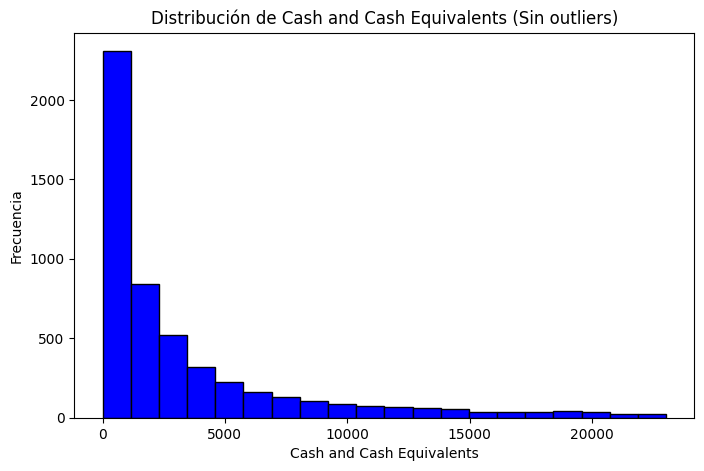

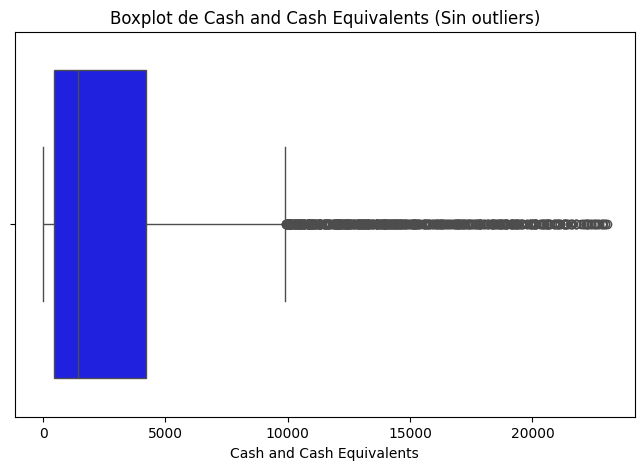

La curtosis para la variable Cash and Cash Equivalents es: 7
El sesgo para la variable Cash and Cash Equivalents es: 2


In [19]:
df_dinero_equivalentes, curtosis_dinero_equivalentes, sesgo_dinero_equivalentes = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_dinero_equivalentes}")
print(f"El sesgo para la variable {variable} es: {sesgo_dinero_equivalentes}")

## Net Sales Revenue Trend (%)

In [20]:
variable = "Net Sales Revenue Trend (%)"
dinero_equivalentes = datos[variable]
dinero_equivalentes.describe()

count      9095.00
mean        458.87
std       15485.51
min        -100.00
25%          -2.65
50%          12.71
75%          34.82
max     1385964.49
Name: Net Sales Revenue Trend (%), dtype: float64

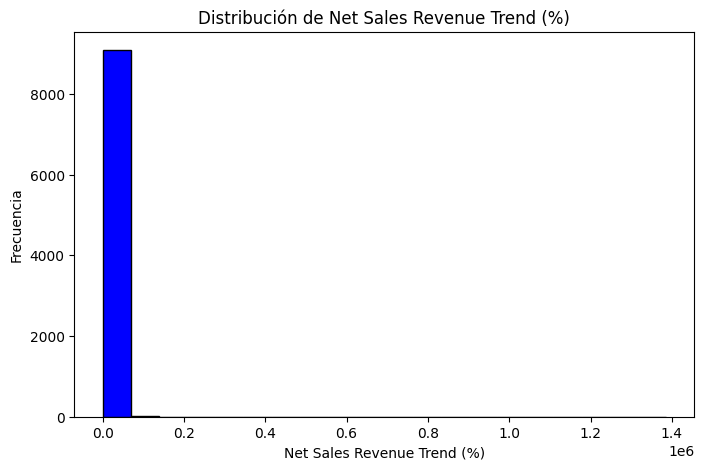

In [21]:
plot_histogram(datos, variable)

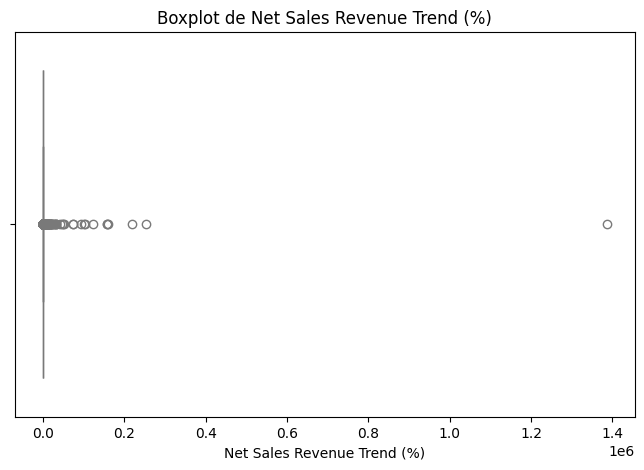

In [22]:
plot_boxplot(datos, variable)

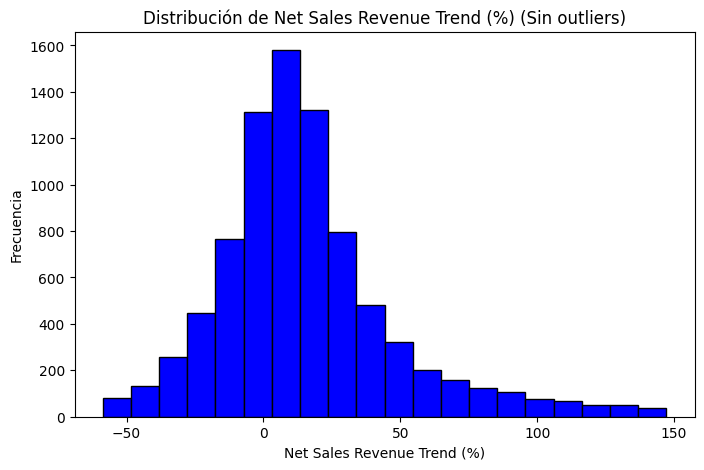

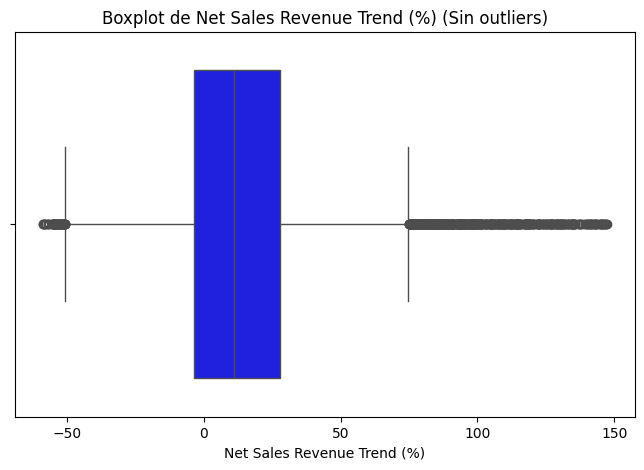

La curtosis para la variable Net Sales Revenue Trend (%) es: 5
El sesgo para la variable Net Sales Revenue Trend (%) es: 1


In [23]:
df_tendencia_ingresos, curtosis_tendencia_ingresos, sesgo_tendencia_ingresos = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_tendencia_ingresos}")
print(f"El sesgo para la variable {variable} es: {sesgo_tendencia_ingresos}")

## Operating Profit Trend (%)

In [24]:
variable = "Operating Profit Trend (%)"
dinero_equivalentes = datos[variable]
dinero_equivalentes.describe()

count      9101.00
mean        390.90
std       27586.51
min     -533666.80
25%         -52.63
50%          -1.02
75%          58.74
max     1890345.07
Name: Operating Profit Trend (%), dtype: float64

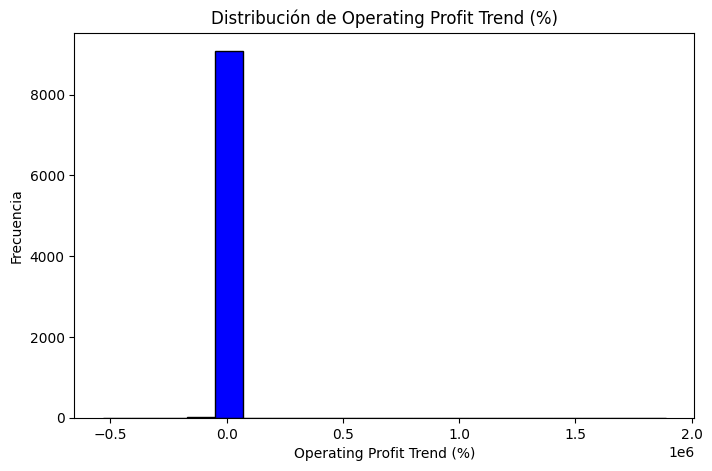

In [25]:
plot_histogram(datos, variable)

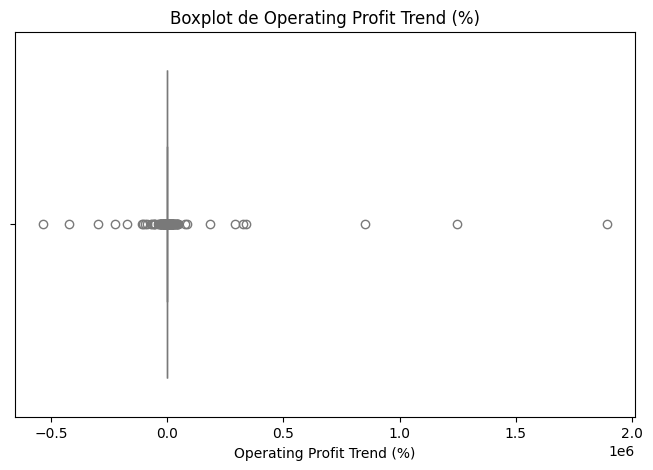

In [26]:
plot_boxplot(datos, variable)

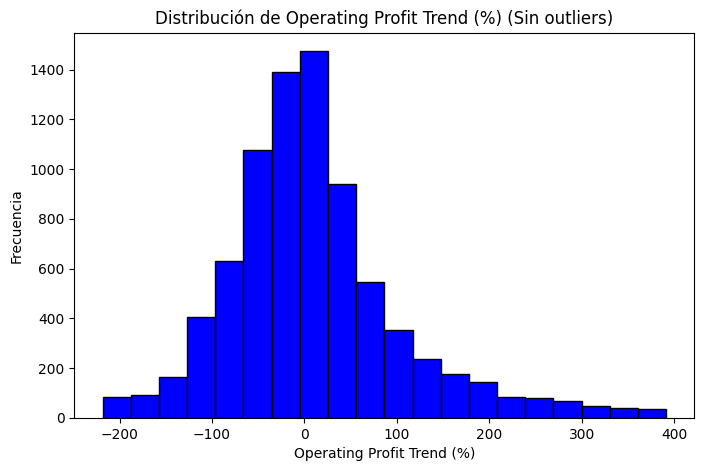

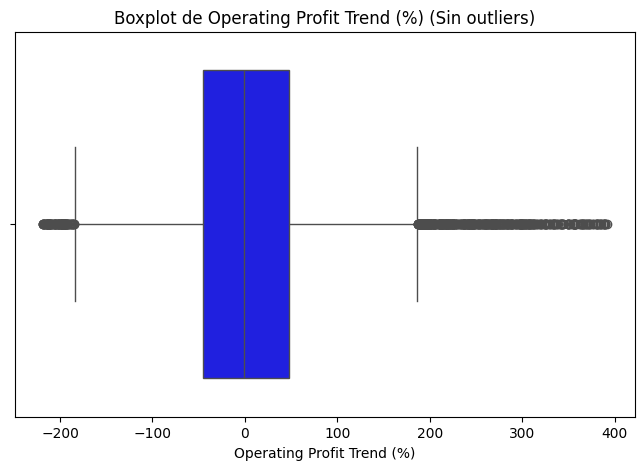

La curtosis para la variable Operating Profit Trend (%) es: 5
El sesgo para la variable Operating Profit Trend (%) es: 1


In [27]:
df_beneficio_operativo, curtosis_beneficio_operativo, sesgo_beneficio_operativo = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_beneficio_operativo}")
print(f"El sesgo para la variable {variable} es: {sesgo_beneficio_operativo}")

## Paises de importación y exportación

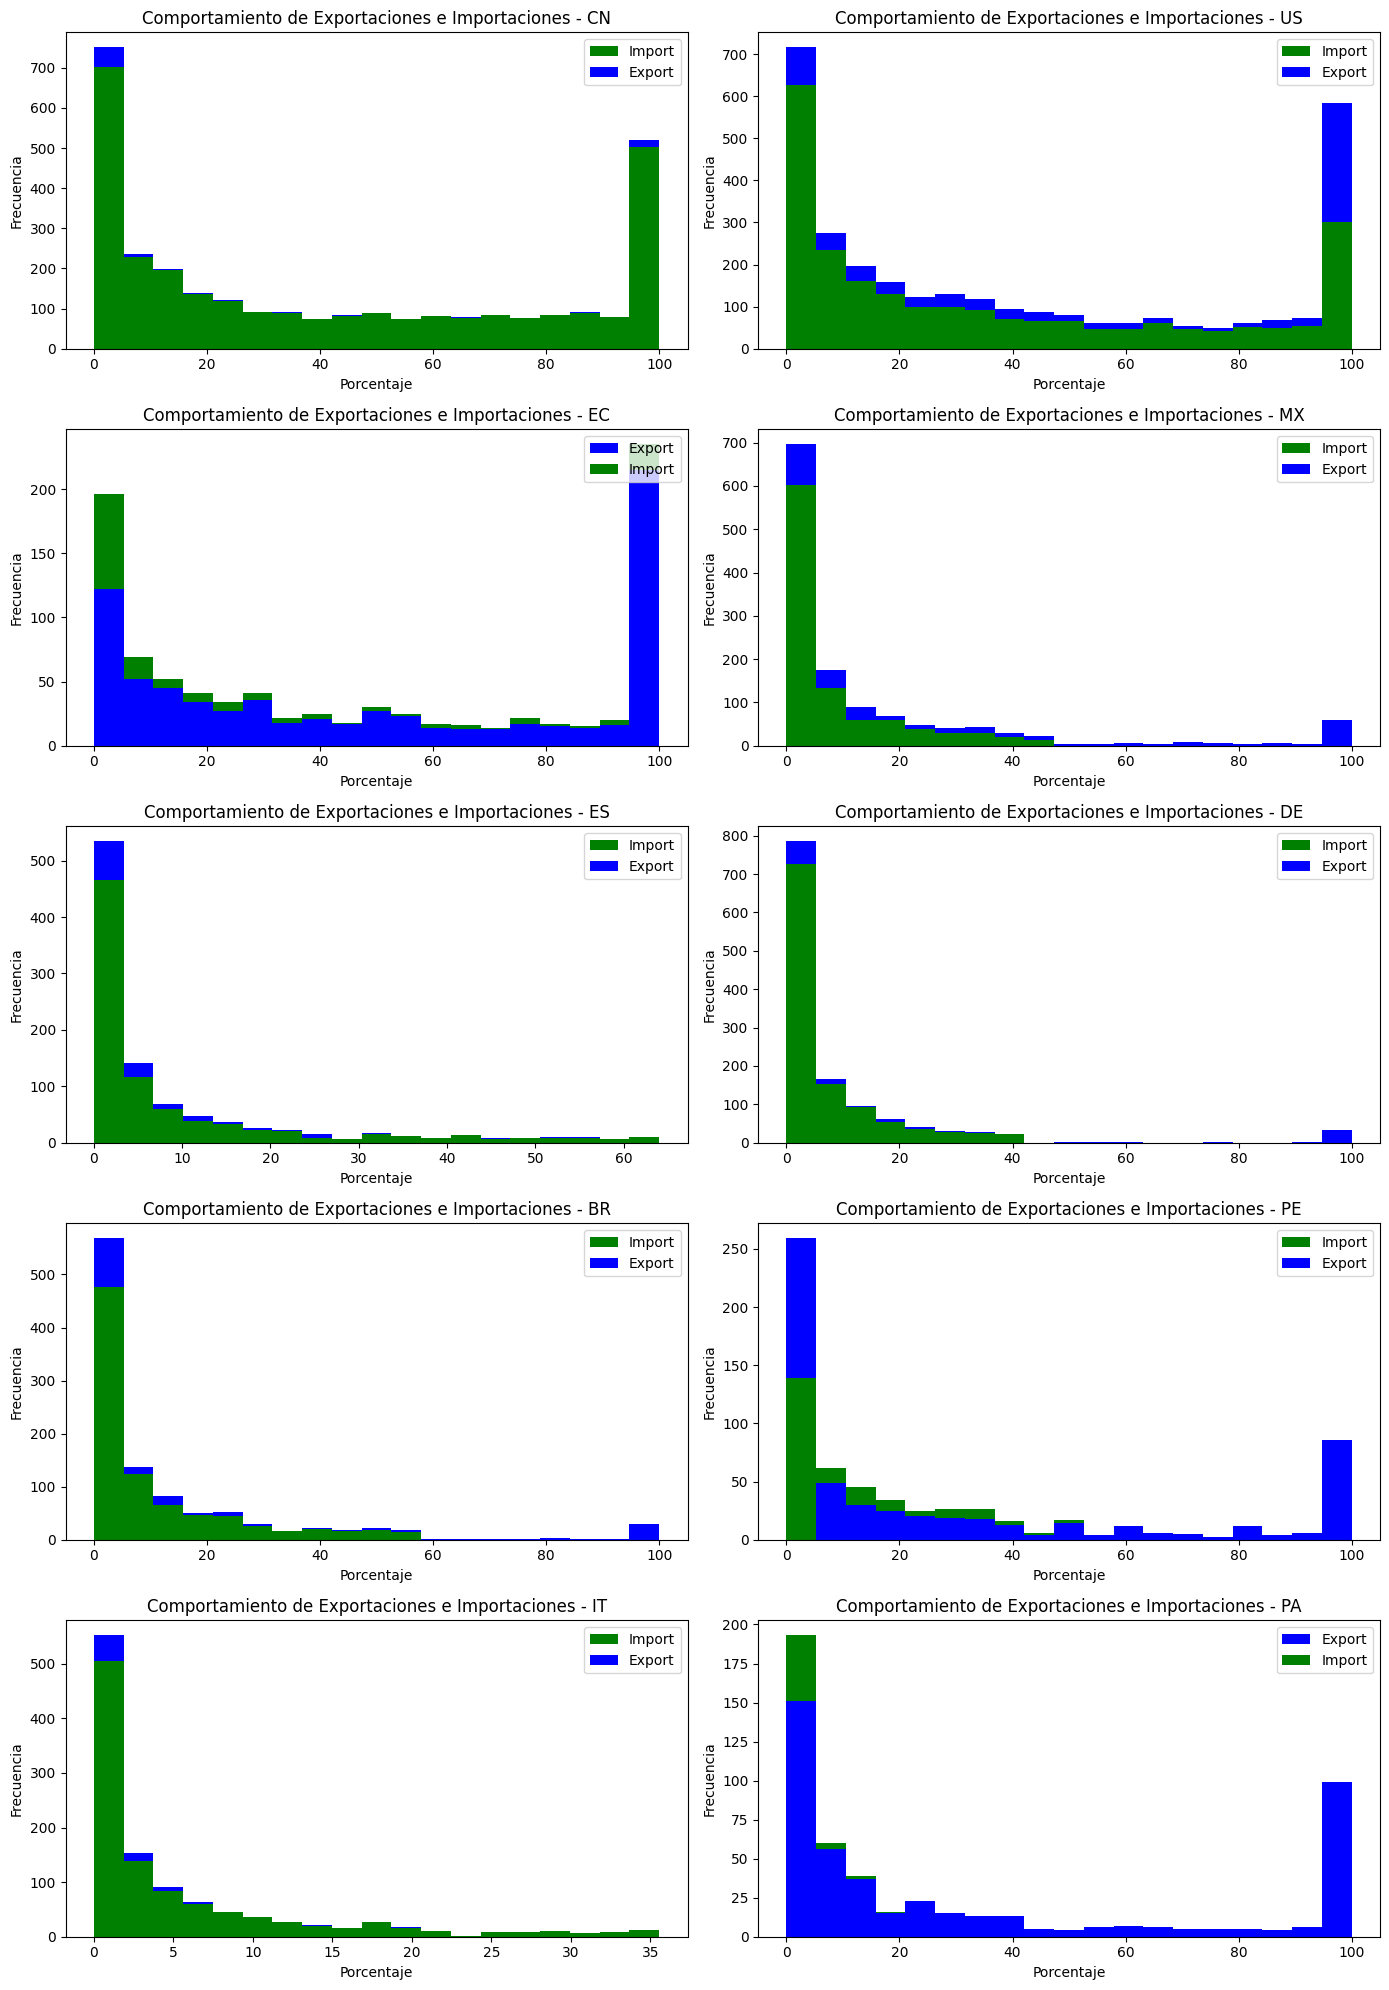

In [28]:
# Función para eliminar outliers utilizando el IQR (Rango Intercuartílico)
def remove_outliers_iqr(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data_column[(data_column >= lower_bound) & (data_column <= upper_bound)]

# Función para eliminar valores en cero
def remove_zero_values(data_column):
    return data_column[data_column != 0]

# Obtener las columnas de exportación e importación del top 10 de países
top_10_export_columns = [col for col in datos.columns if 'Export_' in col]
top_10_import_columns = [col for col in datos.columns if 'Import_' in col]

# Crear un gráfico combinado de subplots para exportaciones e importaciones por país
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  # 5 filas, 2 columnas

# Aplanar los ejes para facilitar el acceso
axes = axes.flatten()

# Iterar sobre las columnas de exportación e importación, eliminar outliers y graficar
for i, (export_col, import_col) in enumerate(zip(top_10_export_columns, top_10_import_columns)):
    # Limpiar los datos: eliminar outliers y valores en cero
    export_data_clean = remove_outliers_iqr(remove_zero_values(datos[export_col].dropna()))
    import_data_clean = remove_outliers_iqr(remove_zero_values(datos[import_col].dropna()))

    # Determinar el rango de los bins utilizando el valor mínimo y máximo entre ambas series (exportaciones e importaciones)
    min_value = min(export_data_clean.min(), import_data_clean.min())
    max_value = max(export_data_clean.max(), import_data_clean.max())

    # Definir los bins comunes para exportaciones e importaciones
    bins = np.linspace(min_value, max_value, 20)

    # Obtener los valores de los histogramas (sin plotearlos)
    export_hist, _ = np.histogram(export_data_clean, bins=bins)
    import_hist, _ = np.histogram(import_data_clean, bins=bins)

    # Dibujar las barras apiladas
    for j in range(len(bins) - 1):
        # El bin mayor será la base
        if export_hist[j] > import_hist[j]:
            axes[i].bar(bins[j], export_hist[j], width=bins[j+1] - bins[j], color='blue', align='edge', label='Export' if j == 0 else "")
            axes[i].bar(bins[j], import_hist[j], width=bins[j+1] - bins[j], bottom=export_hist[j], color='green', align='edge', label='Import' if j == 0 else "")
        else:
            axes[i].bar(bins[j], import_hist[j], width=bins[j+1] - bins[j], color='green', align='edge', label='Import' if j == 0 else "")
            axes[i].bar(bins[j], export_hist[j], width=bins[j+1] - bins[j], bottom=import_hist[j], color='blue', align='edge', label='Export' if j == 0 else "")

    # Título y etiquetas
    country_name = export_col.split("_")[1]  # Obtener el nombre del país
    axes[i].set_title(f'Comportamiento de Exportaciones e Importaciones - {country_name}')
    axes[i].set_xlabel('Porcentaje')
    axes[i].set_ylabel('Frecuencia')

    # Añadir la leyenda solo una vez en cada gráfico
    axes[i].legend(loc='upper right')

# Ajustar el layout
plt.tight_layout()
plt.show()

## Industry (NAICS)

In [29]:
variable = "Industry (NAICS)"
datos[variable].describe(include="object")

count                                                   10000
unique                                                    580
top       Computer Systems Design and Related Services(54151)
freq                                                      334
Name: Industry (NAICS), dtype: object

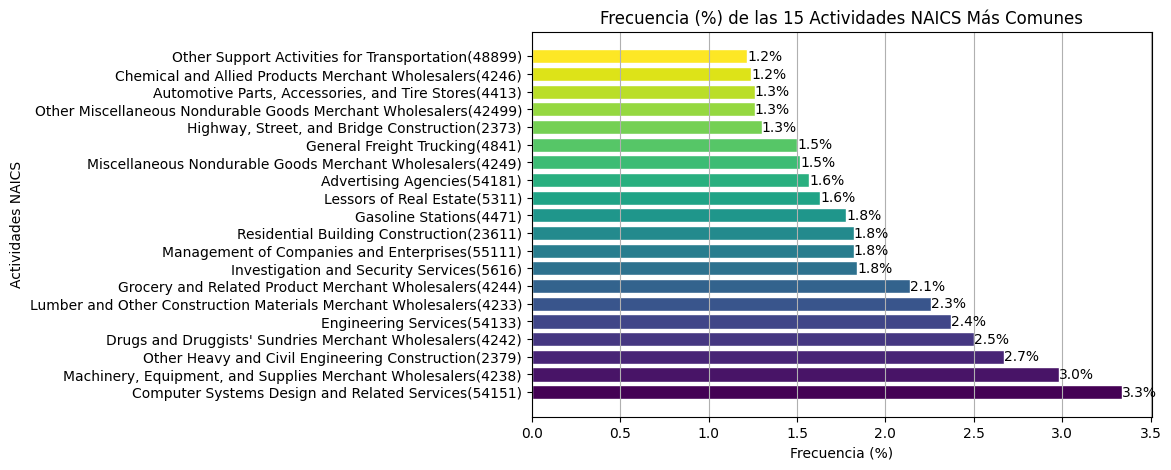

In [30]:
frecuencia_naics = pd.DataFrame(datos[variable].value_counts(normalize=True).head(20)).reset_index(drop=False)
frecuencia_naics['proportion'] = frecuencia_naics['proportion'] * 100
naics_labels = frecuencia_naics[variable]
frequencies = frecuencia_naics['proportion']

plt.figure(figsize=(8, 5))
bars = plt.barh(
    naics_labels,
    frequencies,
    edgecolor='white',
    color=plt.get_cmap('viridis')(np.linspace(0, 1, len(frequencies)))
)

plt.title(
    'Frecuencia (%) de las 15 Actividades NAICS Más Comunes',
    # fontsize=16
)
plt.xlabel(
    'Frecuencia (%)',
    # fontsize=14
)
plt.ylabel(
    'Actividades NAICS',
    # fontsize=14
)
plt.grid(axis='x')

# Etiquetas
for index, value in enumerate(frequencies):
    plt.text(value, index, f'{value:.1f}%', va='center')

plt.show()

## Long term Debt

In [31]:
variable = "Long term Debt"
deuda_largo_plazo = datos[variable]
deuda_largo_plazo.describe()

count       9887.00
mean       28692.39
std      1157929.60
min            0.00
25%            0.00
50%            0.00
75%            0.00
max     90265519.23
Name: Long term Debt, dtype: float64

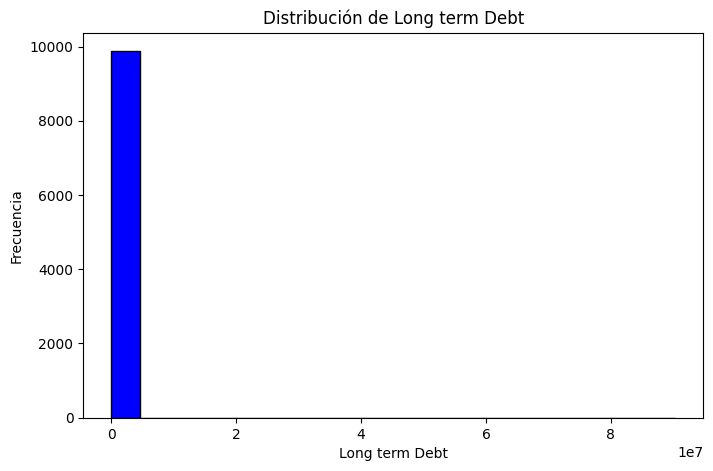

In [32]:
plot_histogram(datos, variable)

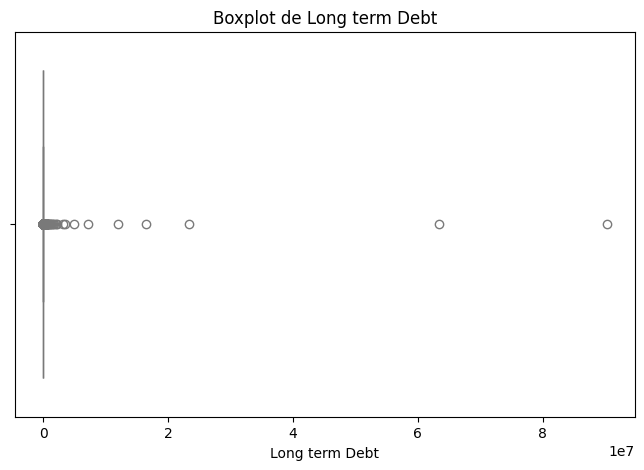

In [33]:
plot_boxplot(datos, variable)

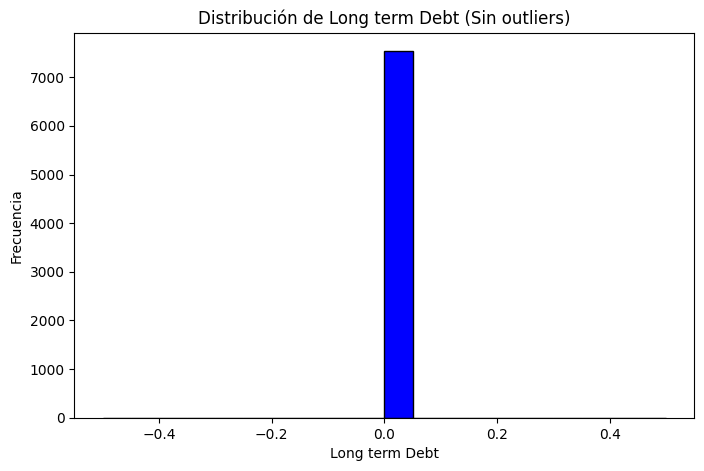

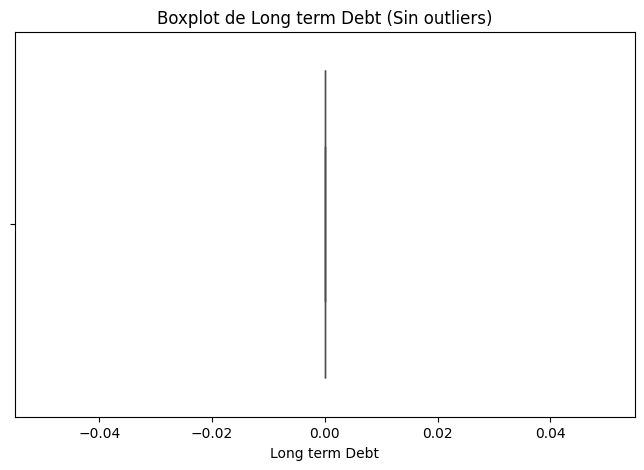

La curtosis para la variable Long term Debt es: nan
El sesgo para la variable Long term Debt es: nan


In [34]:
df_deuda_largo_plazo, curtosis_deuda_largo_plazo, sesgo_deuda_largo_plazo = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_deuda_largo_plazo}")
print(f"El sesgo para la variable {variable} es: {sesgo_deuda_largo_plazo}")

## Short Term Debt

In [35]:
variable = "Short Term Debt"
deuda_corto_plazo = datos[variable]
deuda_corto_plazo.describe()

count       9887.00
mean       18869.45
std      1019690.04
min        -2208.74
25%            0.00
50%            0.00
75%          439.32
max     99837325.25
Name: Short Term Debt, dtype: float64

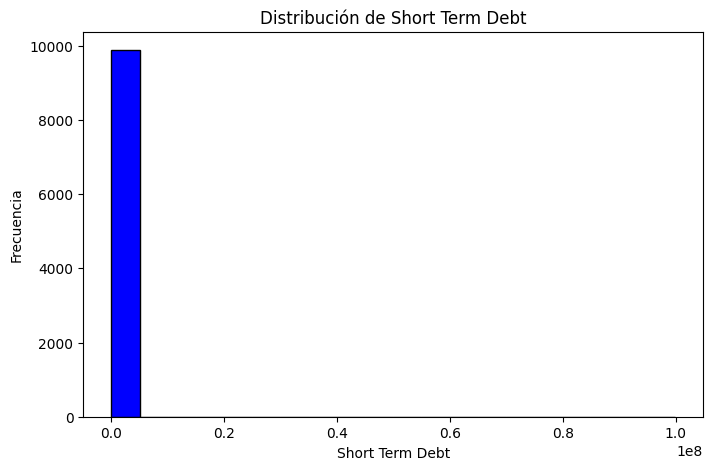

In [36]:
plot_histogram(datos, variable)

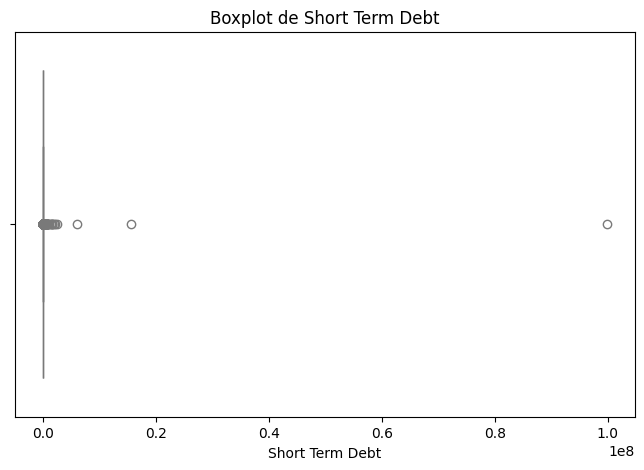

In [37]:
plot_boxplot(datos, variable)

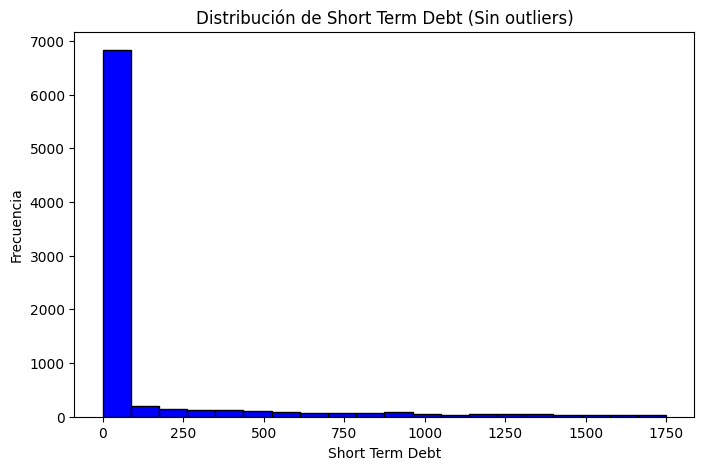

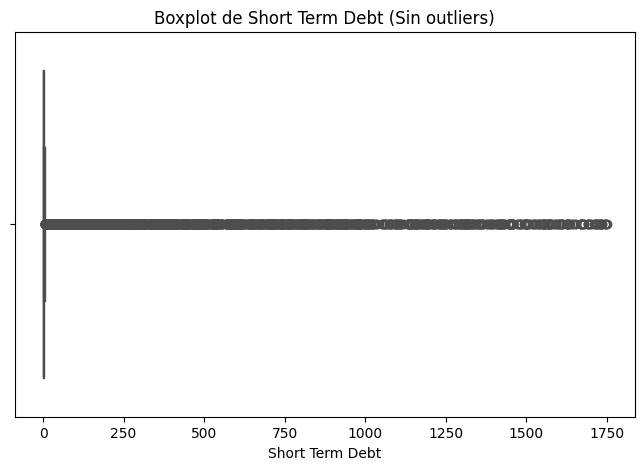

La curtosis para la variable Short Term Debt es: 11
El sesgo para la variable Short Term Debt es: 3


In [38]:
df_deuda_corto_plazo, curtosis_deuda_corto_plazo, sesgo_deuda_corto_plazo = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_deuda_corto_plazo}")
print(f"El sesgo para la variable {variable} es: {sesgo_deuda_corto_plazo}")

## Quick Ratio (x)

In [39]:
variable = "Quick Ratio (x)"
quick_ratio = datos[variable]
quick_ratio.describe()

count   9770.00
mean       6.50
std       72.32
min        0.00
25%        1.02
50%        1.56
75%        2.66
max     3364.73
Name: Quick Ratio (x), dtype: float64

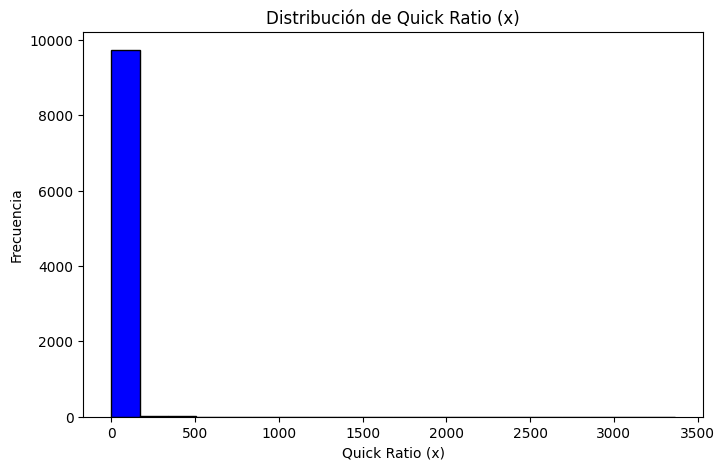

In [40]:
plot_histogram(datos, variable)

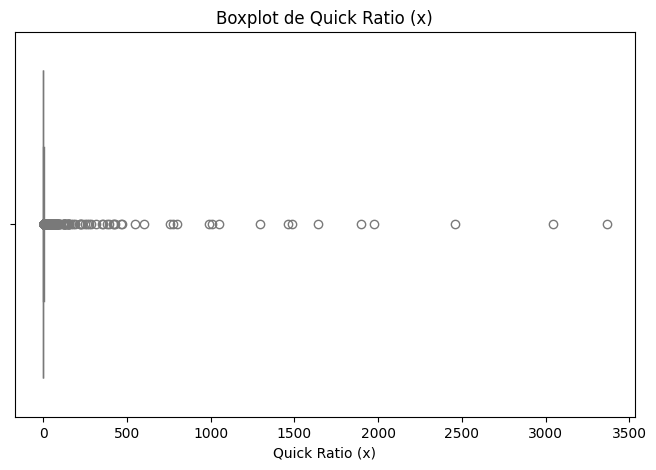

In [41]:
plot_boxplot(datos, variable)

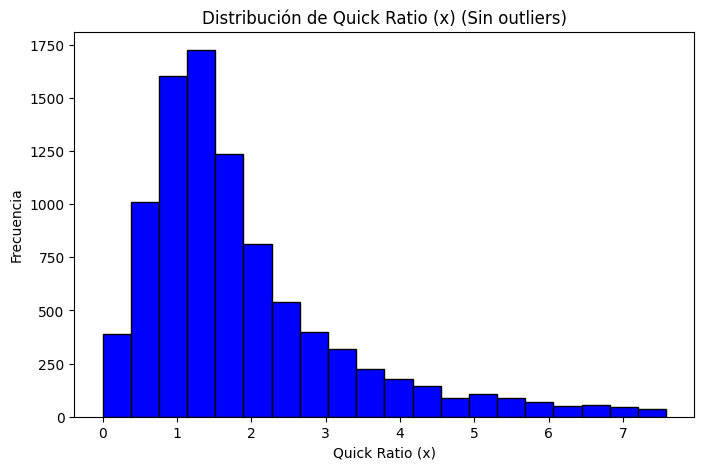

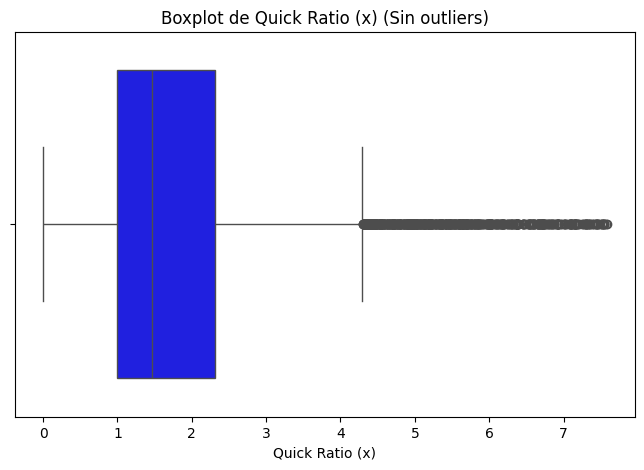

La curtosis para la variable Quick Ratio (x) es: 5
El sesgo para la variable Quick Ratio (x) es: 1


In [42]:
df_quick_ratio, curtosis_quick_ratio, sesgo_quick_ratio = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_quick_ratio}")
print(f"El sesgo para la variable {variable} es: {sesgo_quick_ratio}")

## Total operating revenue

In [43]:
variable = "Total operating revenue"
ingresos_operativos = datos[variable]
ingresos_operativos.describe()

count       10000.00
mean       125803.75
std       1576776.02
min          8082.48
25%         11779.13
50%         19840.62
75%         48385.52
max     142748516.61
Name: Total operating revenue, dtype: float64

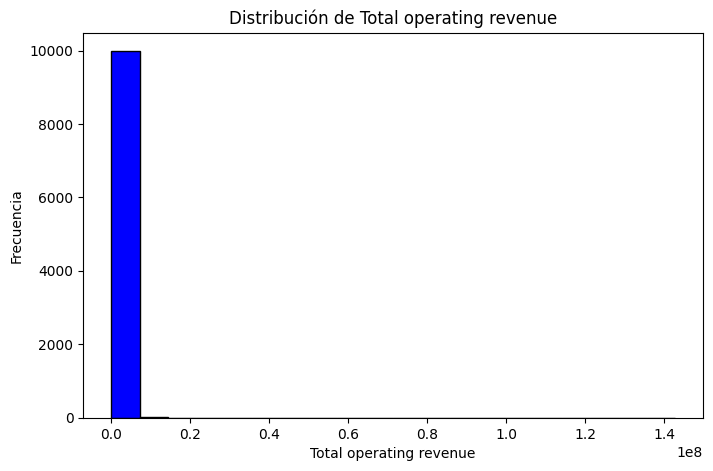

In [44]:
plot_histogram(datos, variable)

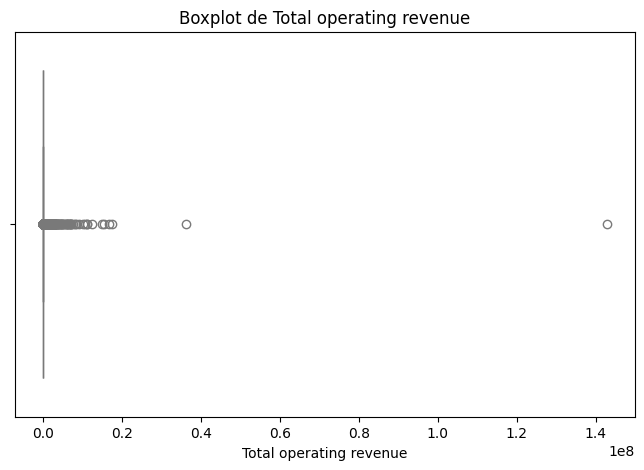

In [45]:
plot_boxplot(datos, variable)

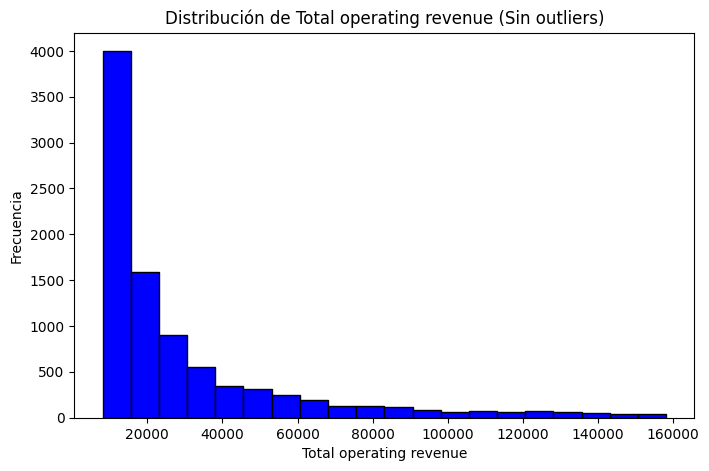

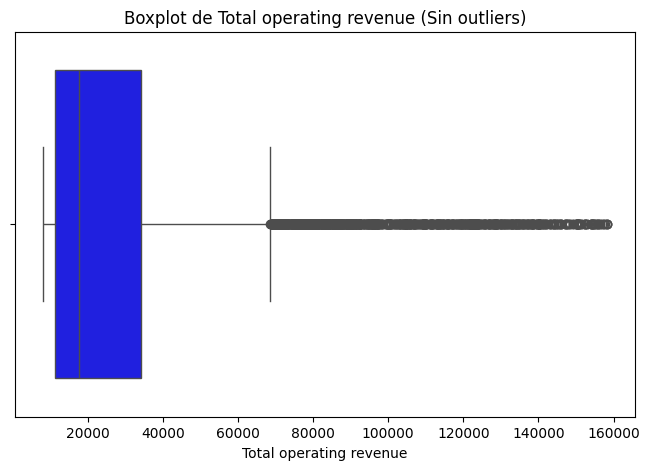

La curtosis para la variable Total operating revenue es: 7
El sesgo para la variable Total operating revenue es: 2


In [46]:
df_ingresos_operativos, curtosis_ingresos_operativos, sesgo_ingresos_operativos = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_ingresos_operativos}")
print(f"El sesgo para la variable {variable} es: {sesgo_ingresos_operativos}")

## Return on Assets (ROA) (%)

In [47]:
variable = "Return on Assets (ROA) (%)"
roa = datos[variable]
roa.describe()

count    10000.00
mean        94.79
std       3515.14
min      -3599.56
25%          1.42
50%          5.91
75%         12.45
max     276923.08
Name: Return on Assets (ROA) (%), dtype: float64

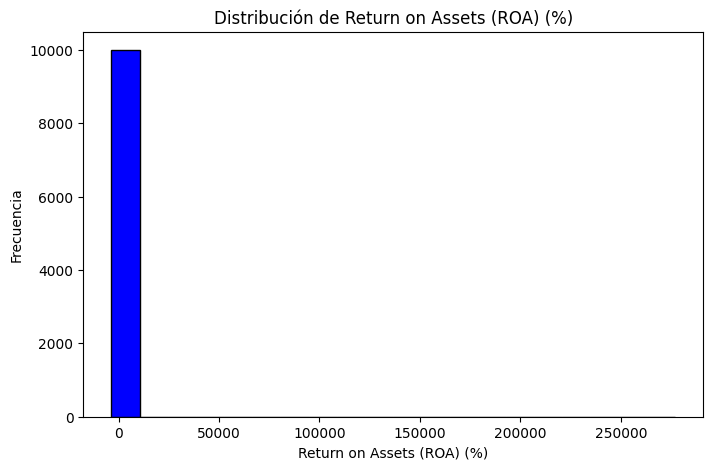

In [48]:
plot_histogram(datos, variable)

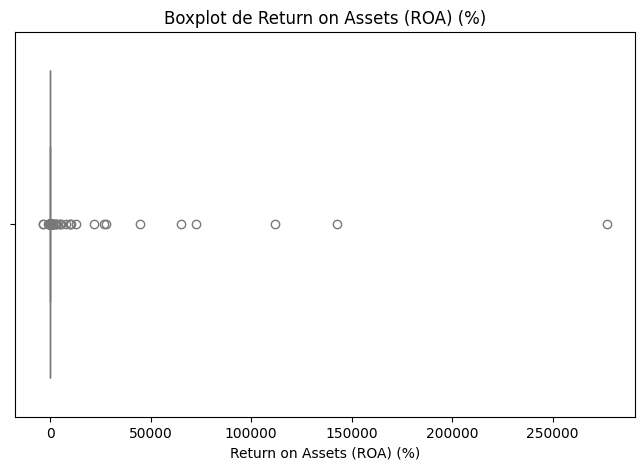

In [49]:
plot_boxplot(datos, variable)

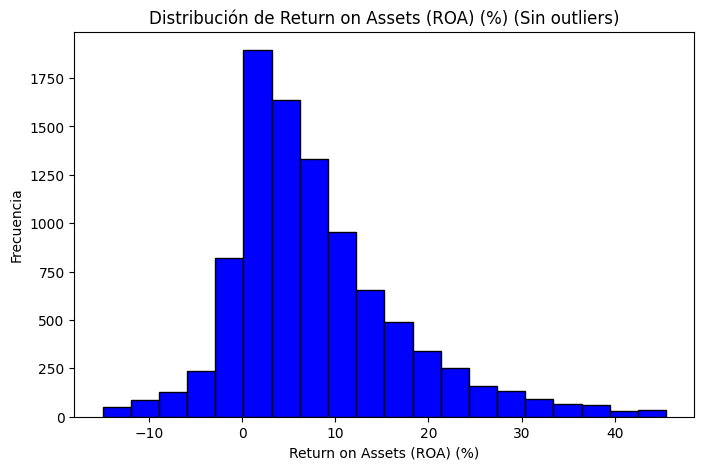

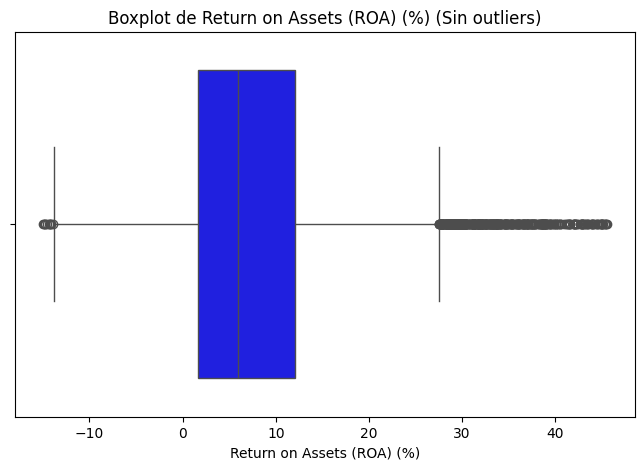

La curtosis para la variable Return on Assets (ROA) (%) es: 4
El sesgo para la variable Return on Assets (ROA) (%) es: 1


In [50]:
df_roa, curtosis_roa, sesgo_roa = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_roa}")
print(f"El sesgo para la variable {variable} es: {sesgo_roa}")

## Return on Equity (ROE) (%)

In [51]:
variable = "Return on Equity (ROE) (%)"
roe = datos[variable]
roe.describe()

count      9964.00
mean         91.75
std        8967.00
min     -735040.22
25%           4.51
50%          14.62
75%          30.34
max      319889.90
Name: Return on Equity (ROE) (%), dtype: float64

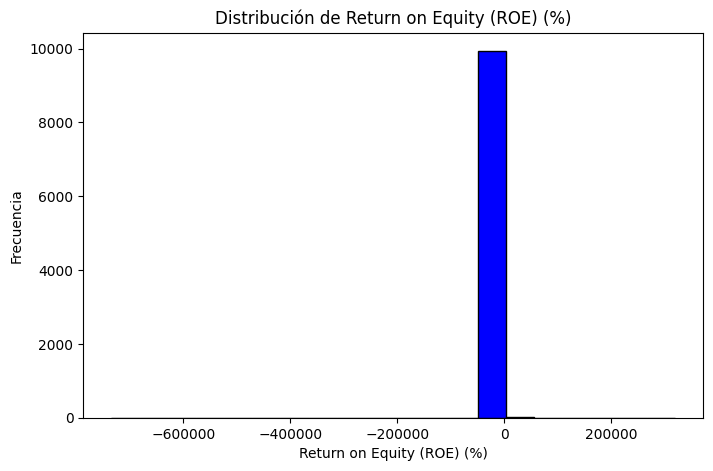

In [52]:
plot_histogram(datos, variable)

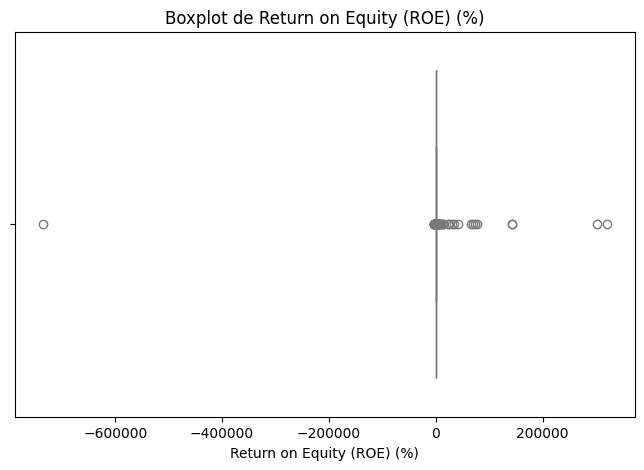

In [53]:
plot_boxplot(datos, variable)

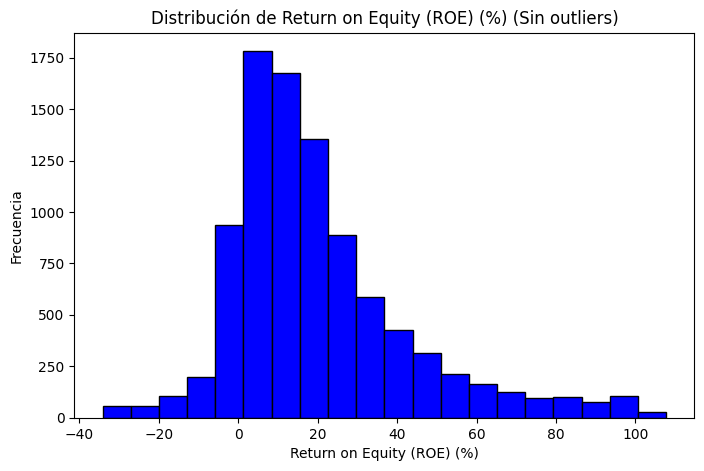

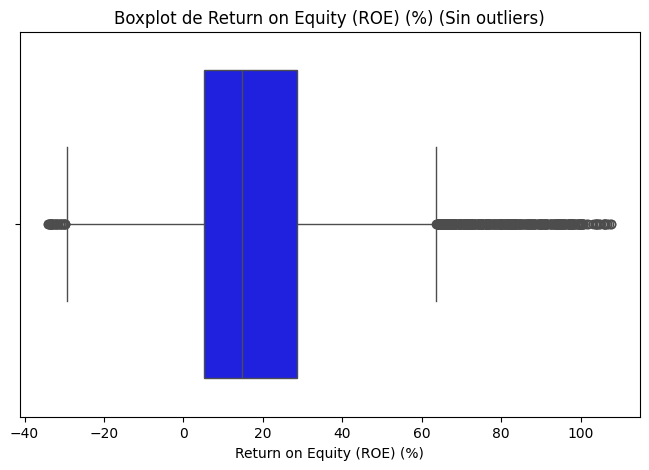

La curtosis para la variable Return on Equity (ROE) (%) es: 5
El sesgo para la variable Return on Equity (ROE) (%) es: 1


In [54]:
df_roe, curtosis_roe, sesgo_roe = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_roe}")
print(f"El sesgo para la variable {variable} es: {sesgo_roe}")

## Employees

In [55]:
variable = "Employees"
empleados = datos[variable]
empleados.describe()

count    9673.00
mean      260.06
std      1412.11
min         1.00
25%        17.00
50%        50.00
75%       146.00
max     73326.00
Name: Employees, dtype: float64

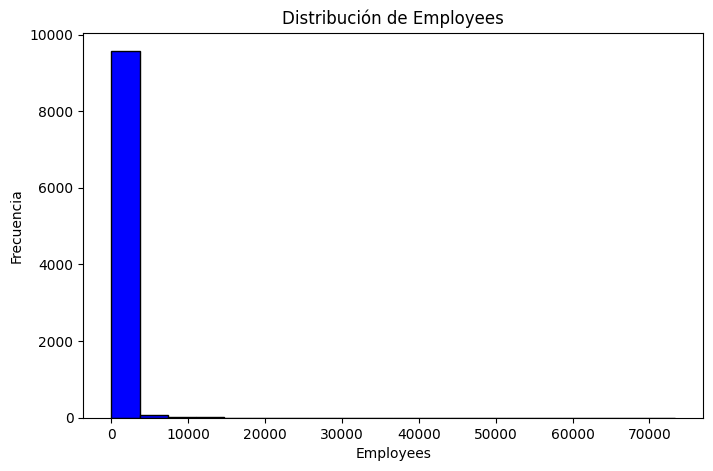

In [56]:
plot_histogram(datos, variable)

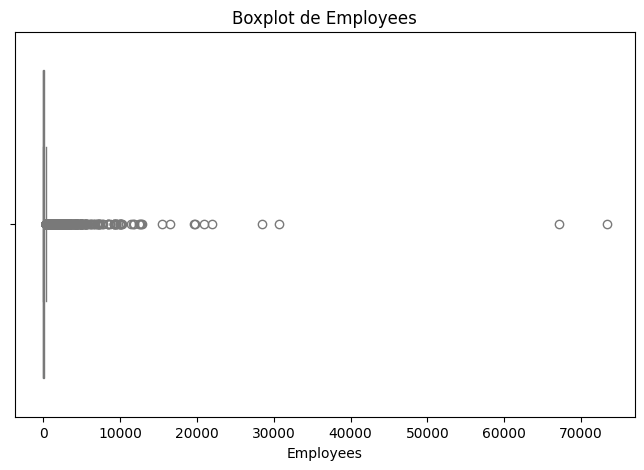

In [57]:
plot_boxplot(datos, variable)

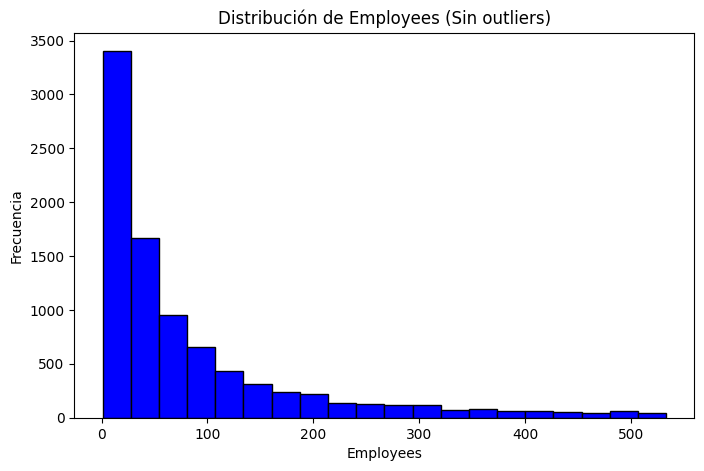

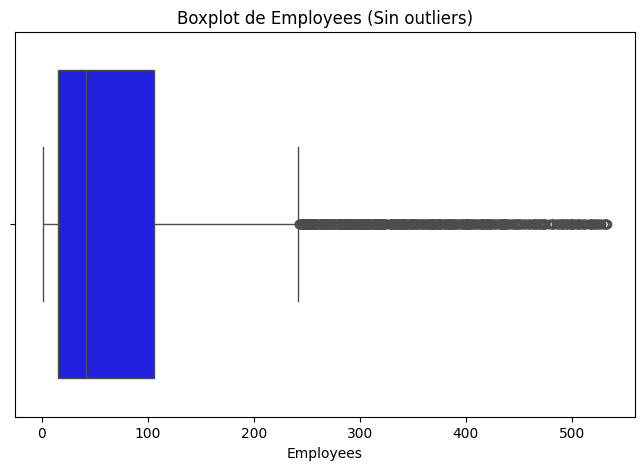

La curtosis para la variable Employees es: 6
El sesgo para la variable Employees es: 2


In [58]:
df_empleados, curtosis_empleados, sesgo_empleados = filter_outliers_iqr_and_plot(datos, variable)
print(f"La curtosis para la variable {variable} es: {curtosis_empleados}")
print(f"El sesgo para la variable {variable} es: {sesgo_empleados}")

# Análisis multivariado

In [59]:
# Pareto
def plot_bar(
        data,
        column,
        # bins=20,
        color='blue',
        edgecolor='black',
        figsize=(8, 5)
    ):
    """
    Función para graficar las industrias que representan el 80% del total
    (principio de Pareto)
    """

    industry_totals = data.groupby('First_Sector')[column].sum().sort_values(ascending=False)
    cumulative_percentage = industry_totals.cumsum() / industry_totals.sum() * 100
    pareto_threshold = cumulative_percentage[cumulative_percentage <= 70]

    plt.figure(figsize=figsize)
    plt.bar(
        pareto_threshold.index,
        pareto_threshold.values,
        color=color,
        edgecolor=edgecolor
    )
    plt.title(f'Pareto de Industrias basadas en {column}')
    plt.xlabel('Sector Industrial')
    plt.ylabel(f'Porcentaje Acumulado de {column}')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

def graficar_box_por_industria(data, columna, IQR_PROP = 1.5):
    
    industry_totals = data.groupby('First_Sector')[columna].sum().sort_values(ascending=False)
    cumulative_percentage = industry_totals.cumsum() / industry_totals.sum() * 100
    pareto_threshold = cumulative_percentage[cumulative_percentage <= 70]

    # Filtrar el DataFrame original para incluir solo las industrias del análisis de Pareto (top 20%)
    pareto_industries = pareto_threshold.index
    filtered_df = datos[datos['First_Sector'].isin(pareto_industries)]

    # Calcular los límites de los outliers utilizando el rango intercuartílico (IQR)
    Q1 = filtered_df[columna].quantile(0.25)
    Q3 = filtered_df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites inferior y superior para los valores no considerados outliers
    lower_bound = Q1 - IQR_PROP * IQR
    upper_bound = Q3 + IQR_PROP * IQR

    # Filtrar los datos eliminando los outliers
    filtered_df_no_outliers = filtered_df[(filtered_df[columna] >= lower_bound) & 
                                        (filtered_df[columna] <= upper_bound)]

    # Crear el boxplot sin los outliers
    plt.figure(figsize=(12,8))
    sns.boxplot(x='First_Sector', y=columna, data=filtered_df_no_outliers)
    plt.title(f'Distribución de {columna} en las Principales Industrias (Sin Outliers)')
    plt.xlabel('Sector Industrial')
    plt.ylabel(columna)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [60]:
datos = datos.drop(
    ["Import", "Export", "Industry (NAICS)", "Number of Employees"],
    axis=1
)

In [61]:
datos.sample(3)

Company  Cash and Cash Equivalents  \
4820                  Servimedios S.A.S                    2504.43   
9116       Inversiones Camilo Rojas Sas                        NaN   
6321  T F Auditores y Asesores Ltda Bic                    1279.72   

      Long term Debt  Net Sales Revenue Trend (%)  Operating Profit Trend (%)  \
4820            0.00                        31.30                       86.18   
9116            0.00                        -9.28                      722.59   
6321         1100.27                        15.58                       92.11   

      Property, plant and equipment  Return on Assets (ROA) (%)  \
4820                        2100.91                       15.45   
9116                           0.00                        9.34   
6321                         159.93                        3.17   

      Return on Equity (ROE) (%)  Quick Ratio (x)  Short Term Debt  \
4820                       26.94             1.88             0.00   
9116                       15.27             2.22             0.00   
6321                        7.67             2.12             4.67   

      Total operating revenue  Employees  Export_CN  Import_CN  Export_US  \
4820                 20827.97      27.00       0.00       0.00       0.00   
9116                  9122.04      11.00       0.00       0.00       0.00   
6321                 14562.23     190.00       0.00       0.00       0.00   

      Import_US  Export_EC  Import_EC  Export_MX  Import_MX  Export_ES  \
4820       0.00       0.00       0.00       0.00       0.00       0.00   
9116       0.00       0.00       0.00       0.00       0.00       0.00   
6321       0.00       0.00       0.00       0.00       0.00       0.00   

      Import_ES  Export_DE  Import_DE  Export_BR  Import_BR  Export_PE  \
4820       0.00       0.00       0.00       0.00       0.00       0.00   
9116       0.00       0.00       0.00       0.00       0.00       0.00   
6321       0.00       0.00       0.00       0.00       0.00       0.00   

      Import_PE  Export_IT  Import_IT  Export_PA  Import_PA  \
4820       0.00       0.00       0.00       0.00       0.00   
9116       0.00       0.00       0.00       0.00       0.00   
6321       0.00       0.00       0.00       0.00       0.00   

                                                               First_Sector  
4820                                            Advertising Agencies(54181)  
9116     Lumber and Other Construction Materials Merchant Wholesalers(4233)  
6321  Accounting, Tax Preparation, Bookkeeping, and Payroll Services(54121)

In [62]:
datos.to_csv("datos/Pruebas.csv")

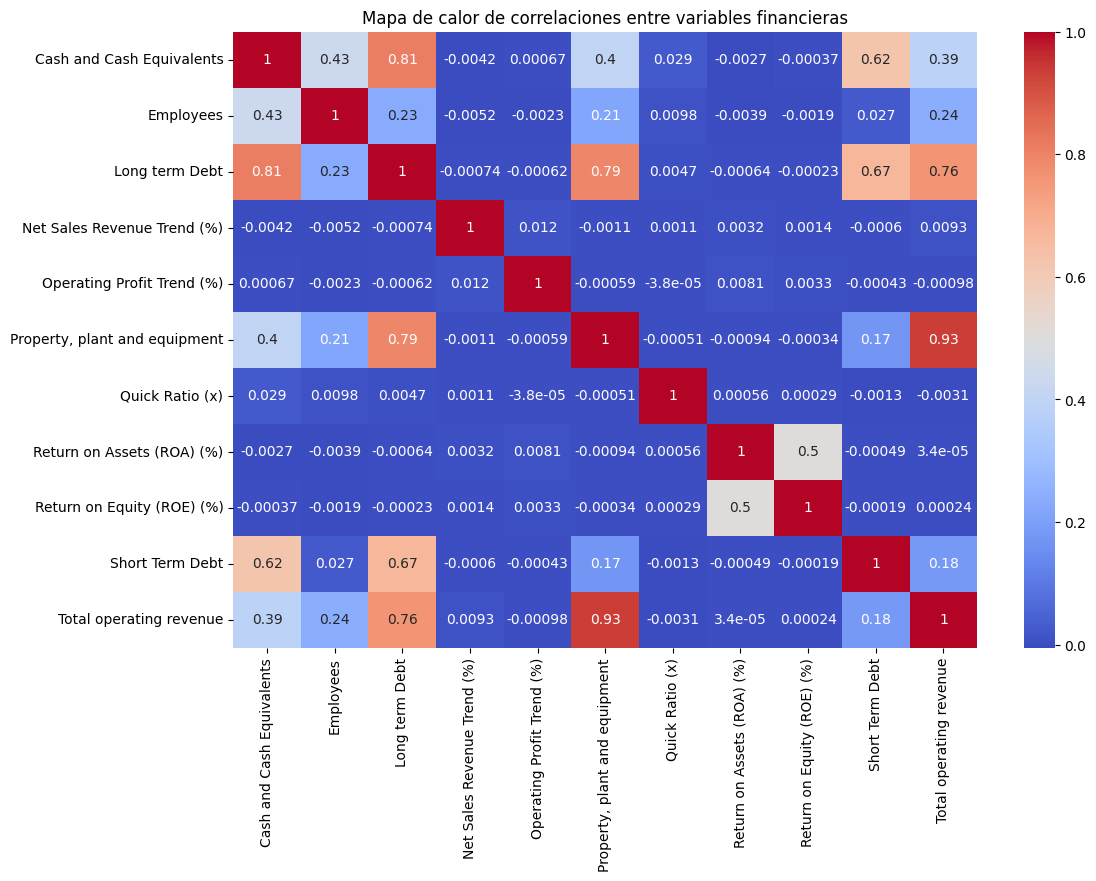

In [63]:
# Mapa de calor: Correlación entre variables financieras
variables = [
    'Cash and Cash Equivalents',
    "Employees",
    "Long term Debt",
    'Net Sales Revenue Trend (%)',
    'Operating Profit Trend (%)',
    'Property, plant and equipment',
    "Quick Ratio (x)",
    "Return on Assets (ROA) (%)",
    "Return on Equity (ROE) (%)",
    "Short Term Debt",
    "Total operating revenue"
]
plt.figure(figsize=(12,8))
sns.heatmap(datos[variables].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones entre variables financieras')
plt.show()

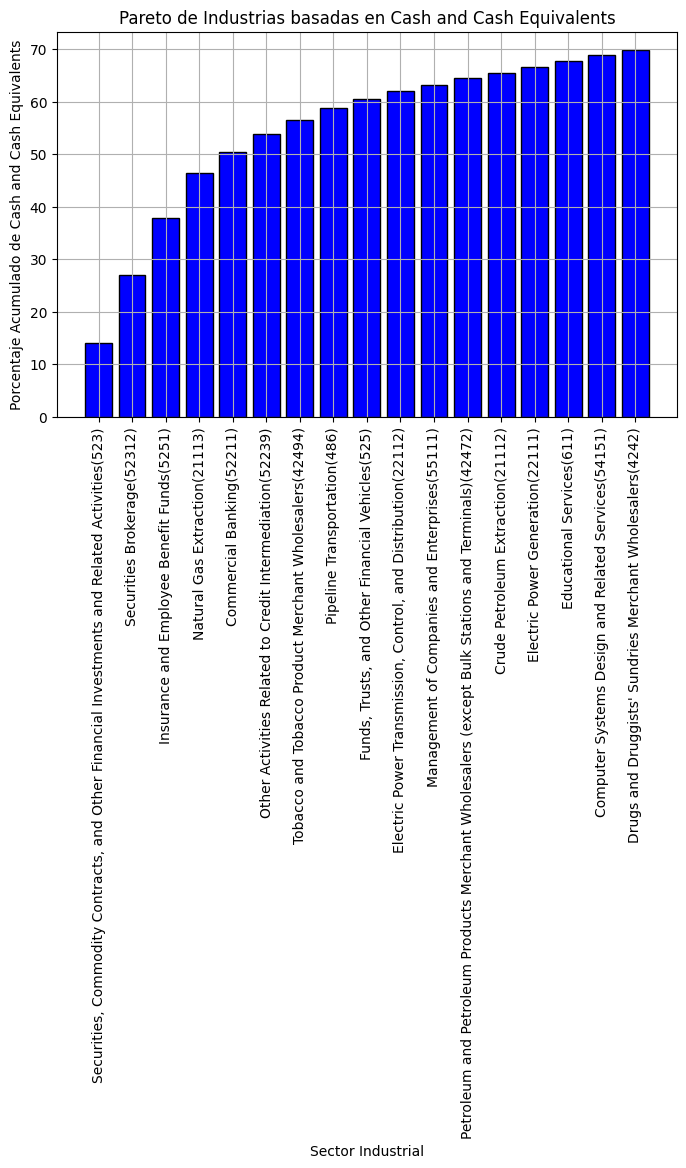

In [64]:
plot_bar(datos, "Cash and Cash Equivalents")

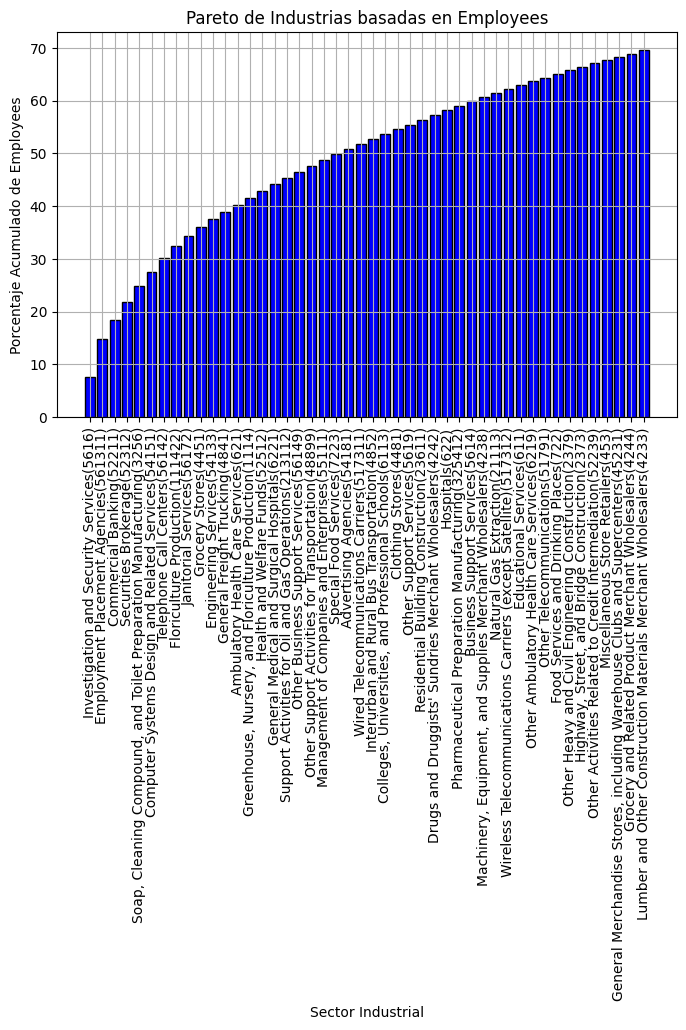

In [65]:
plot_bar(datos, "Employees")

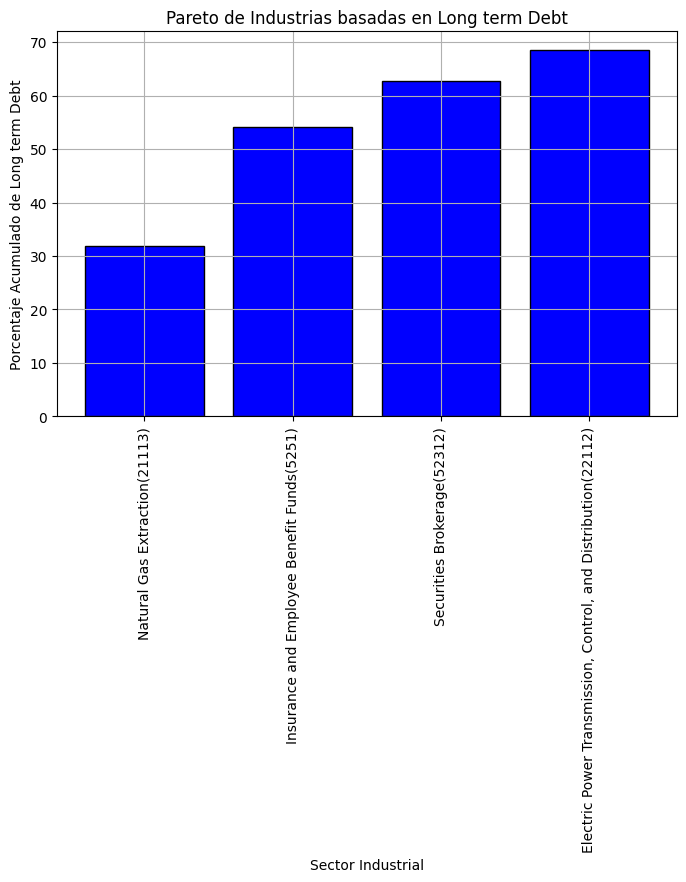

In [66]:
plot_bar(datos, "Long term Debt")

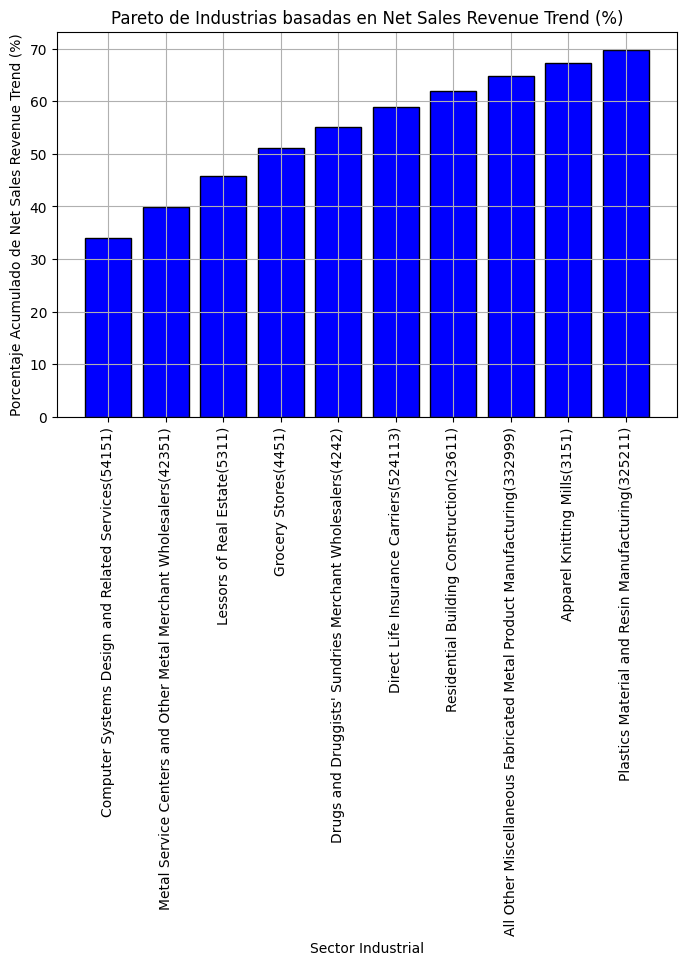

In [67]:
plot_bar(datos, "Net Sales Revenue Trend (%)")

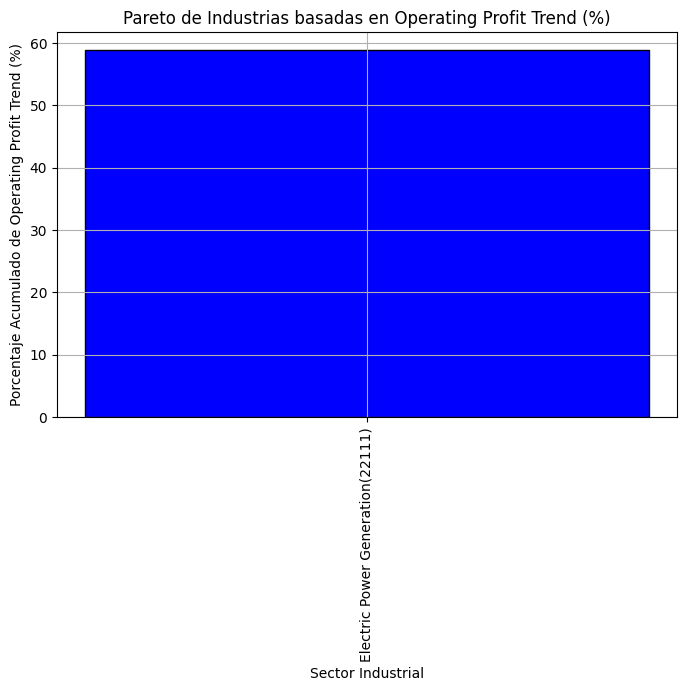

In [68]:
plot_bar(datos, "Operating Profit Trend (%)")

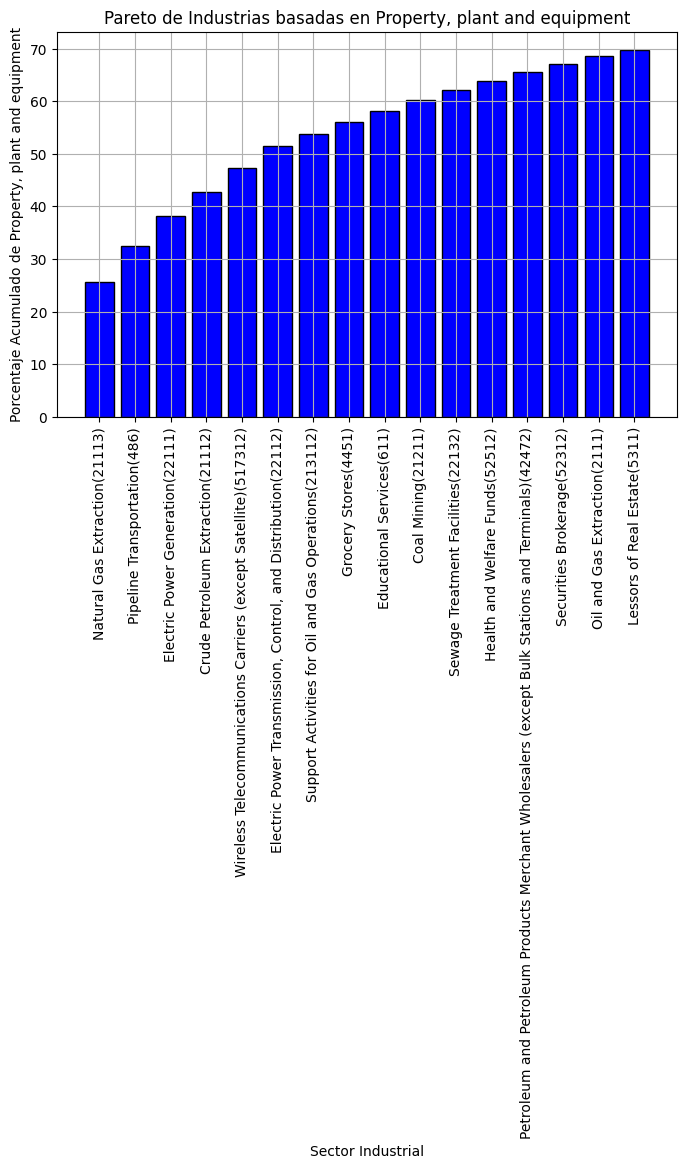

In [69]:
plot_bar(datos, "Property, plant and equipment")

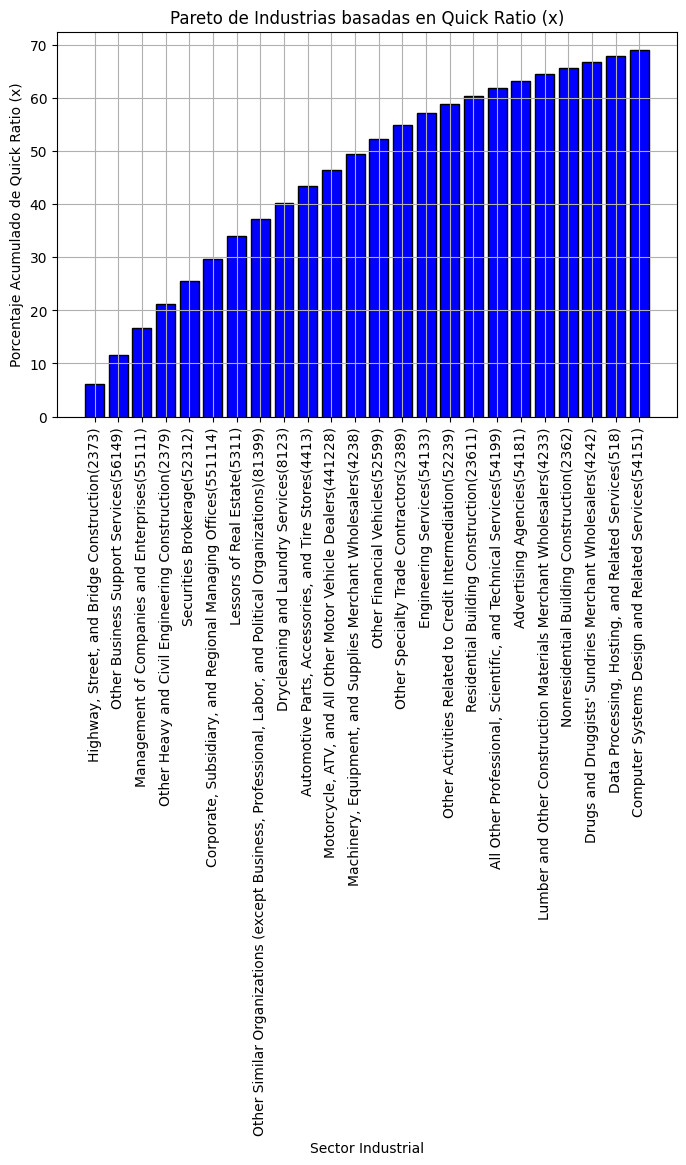

In [70]:
plot_bar(datos, "Quick Ratio (x)")

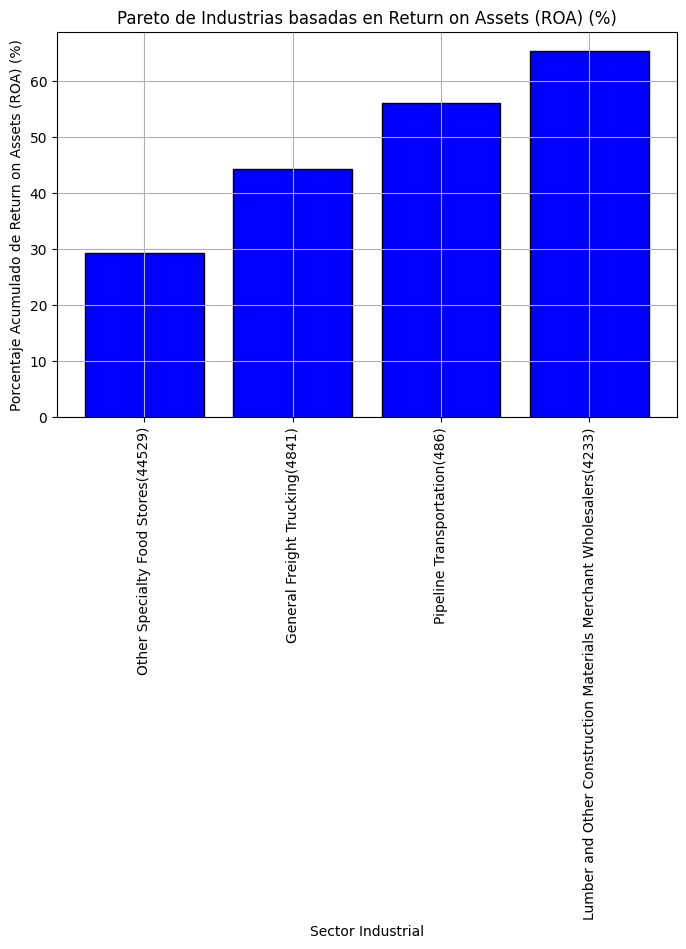

In [71]:
plot_bar(datos, "Return on Assets (ROA) (%)")

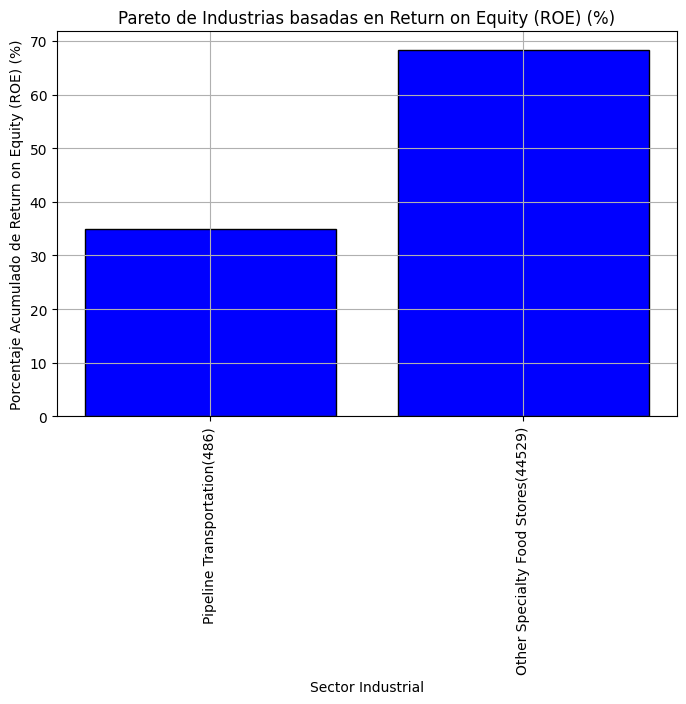

In [72]:
plot_bar(datos, "Return on Equity (ROE) (%)")

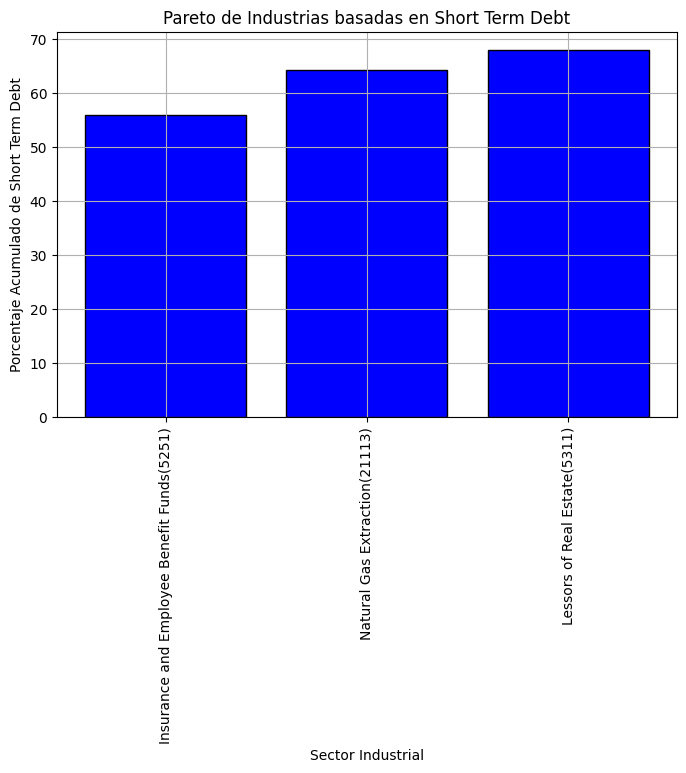

In [73]:
plot_bar(datos, "Short Term Debt")

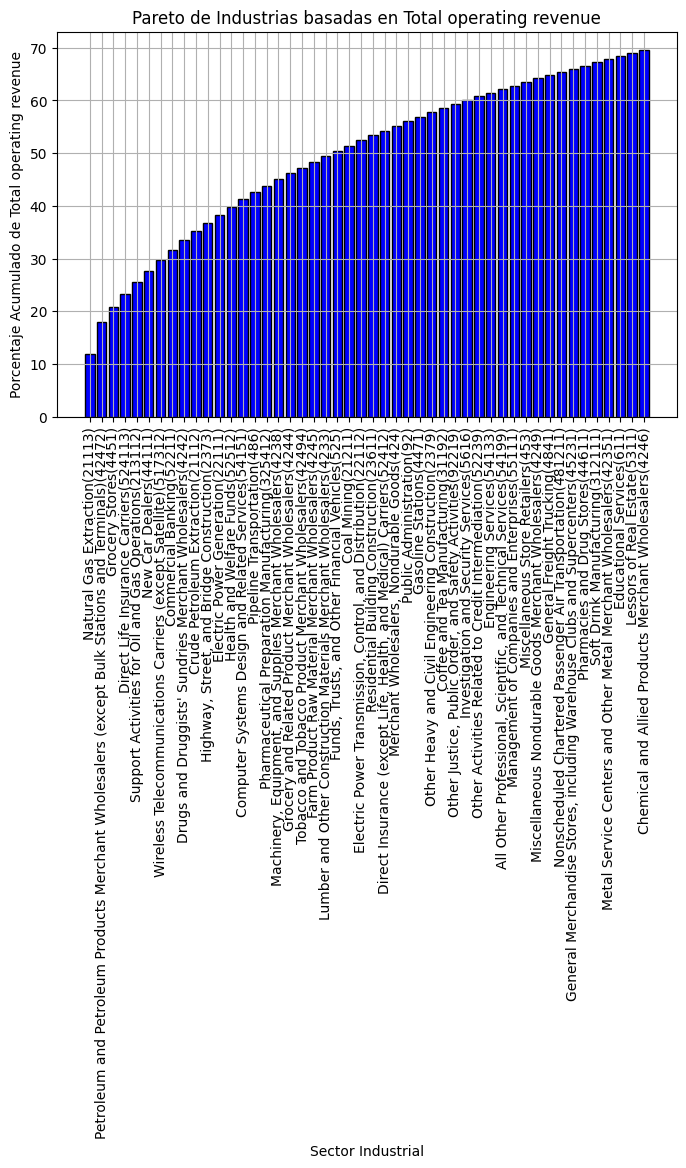

In [74]:
plot_bar(datos, "Total operating revenue")

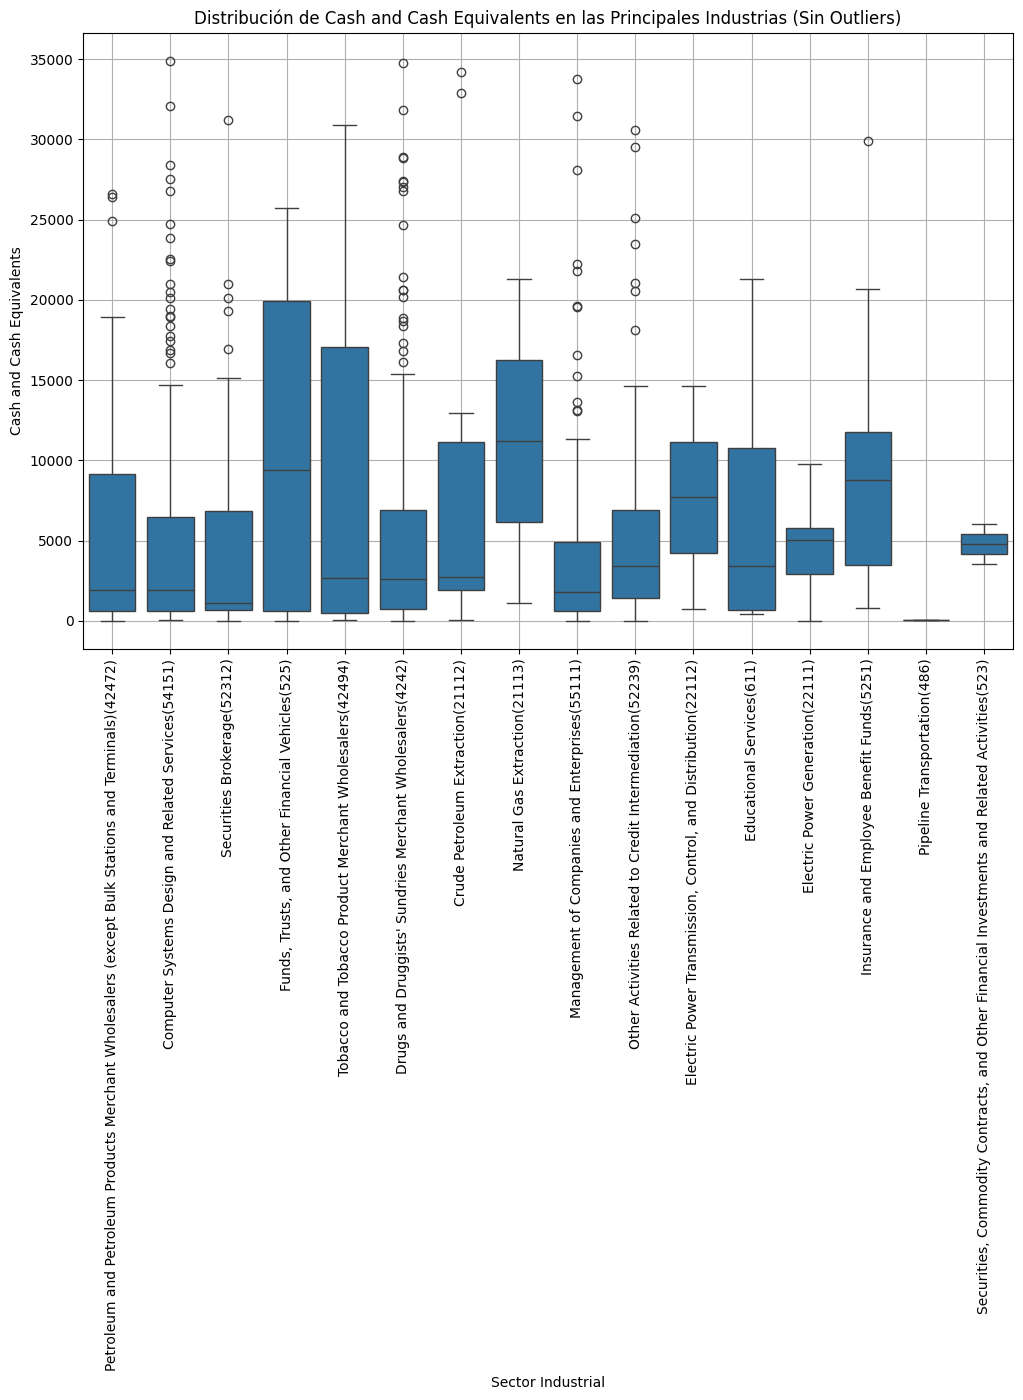

In [75]:
graficar_box_por_industria(datos, "Cash and Cash Equivalents")

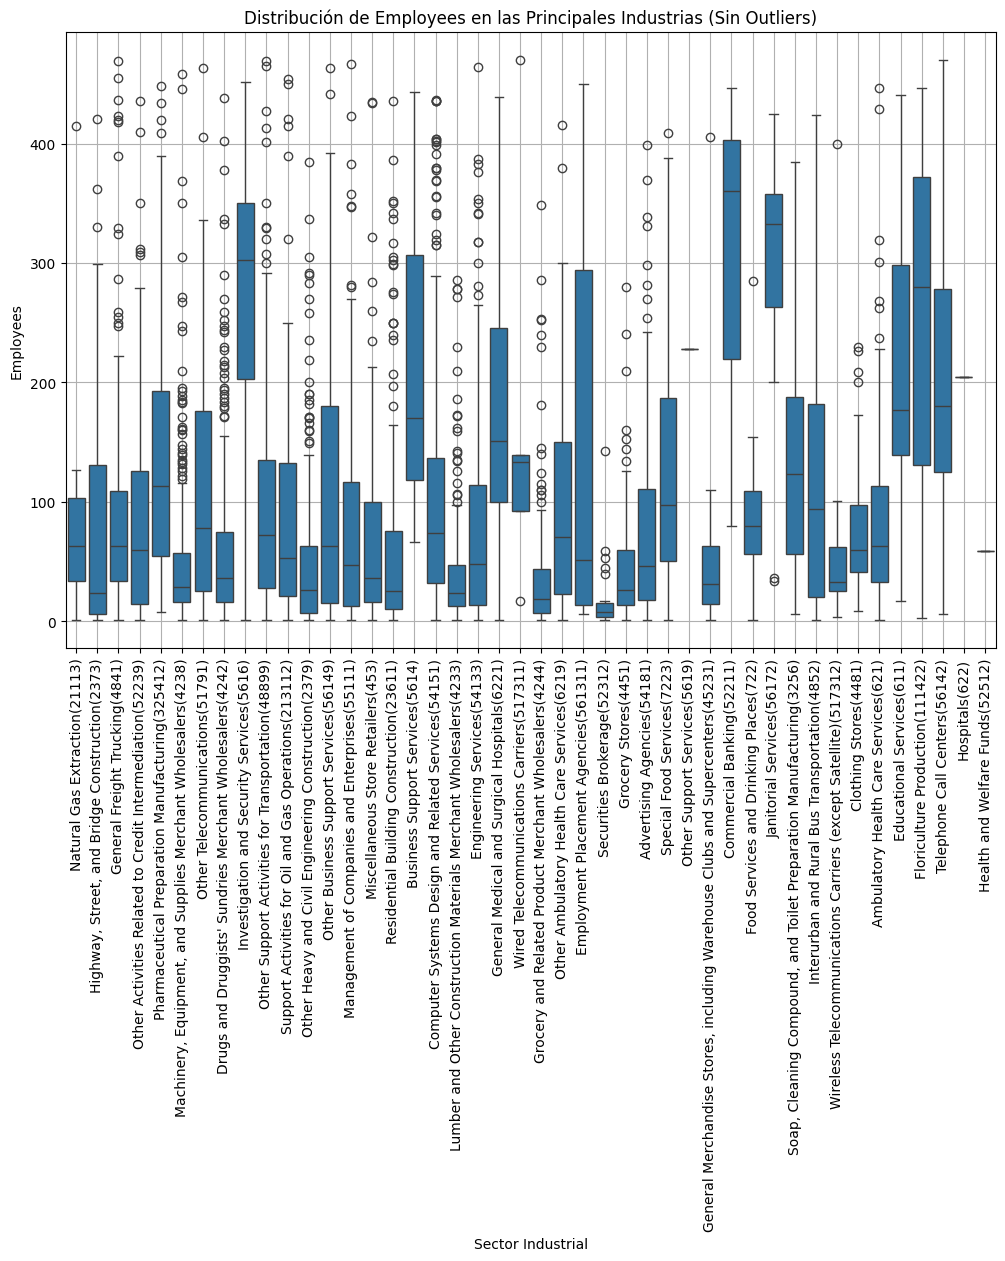

In [76]:
graficar_box_por_industria(datos, "Employees")

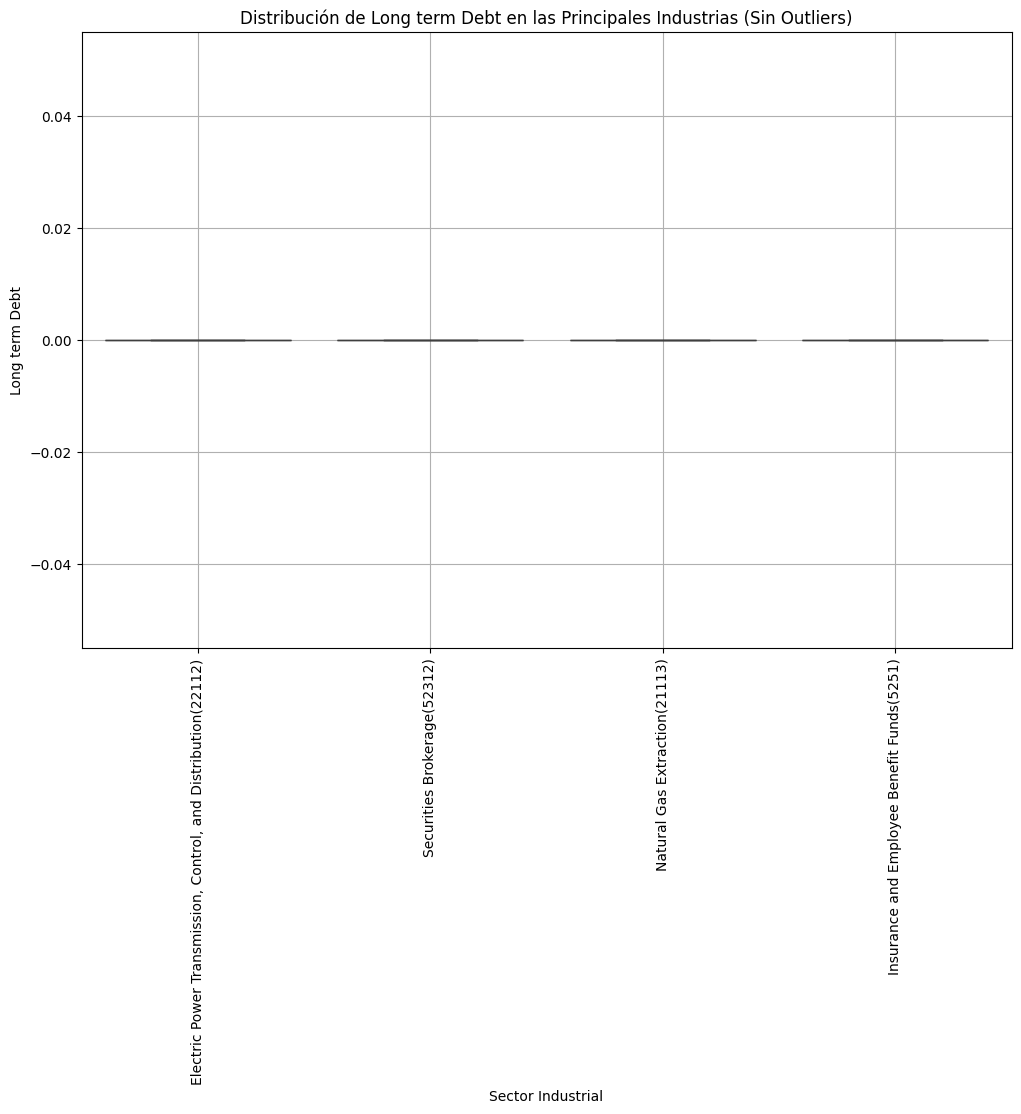

In [77]:
graficar_box_por_industria(datos, "Long term Debt")

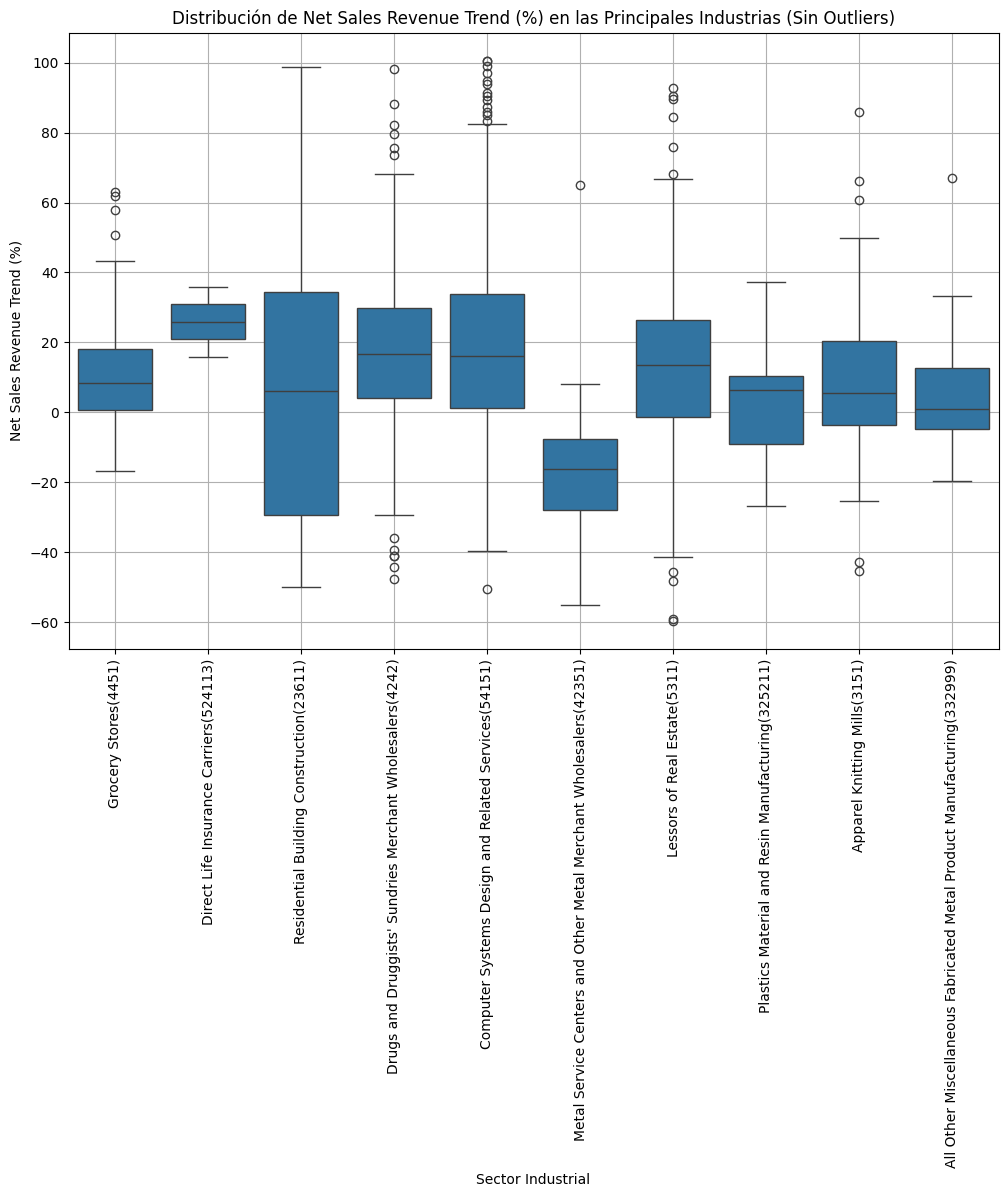

In [78]:
graficar_box_por_industria(datos, "Net Sales Revenue Trend (%)")

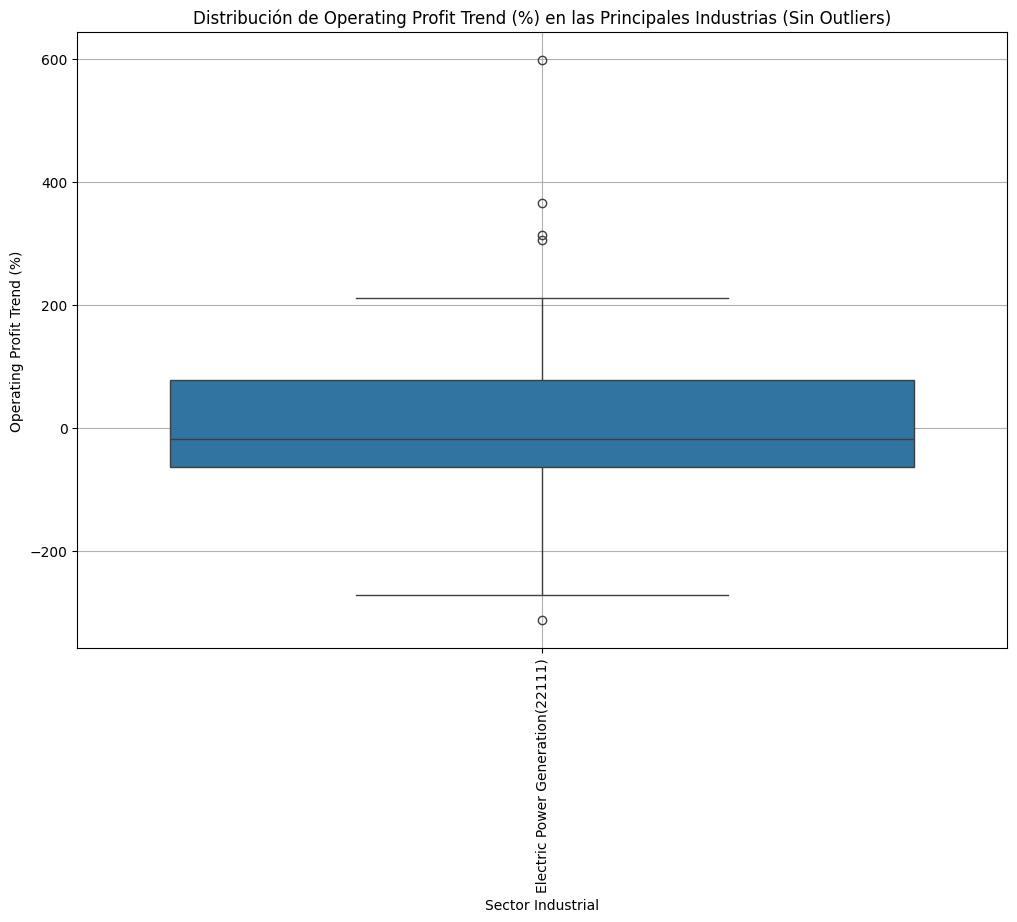

In [79]:
graficar_box_por_industria(datos, "Operating Profit Trend (%)")

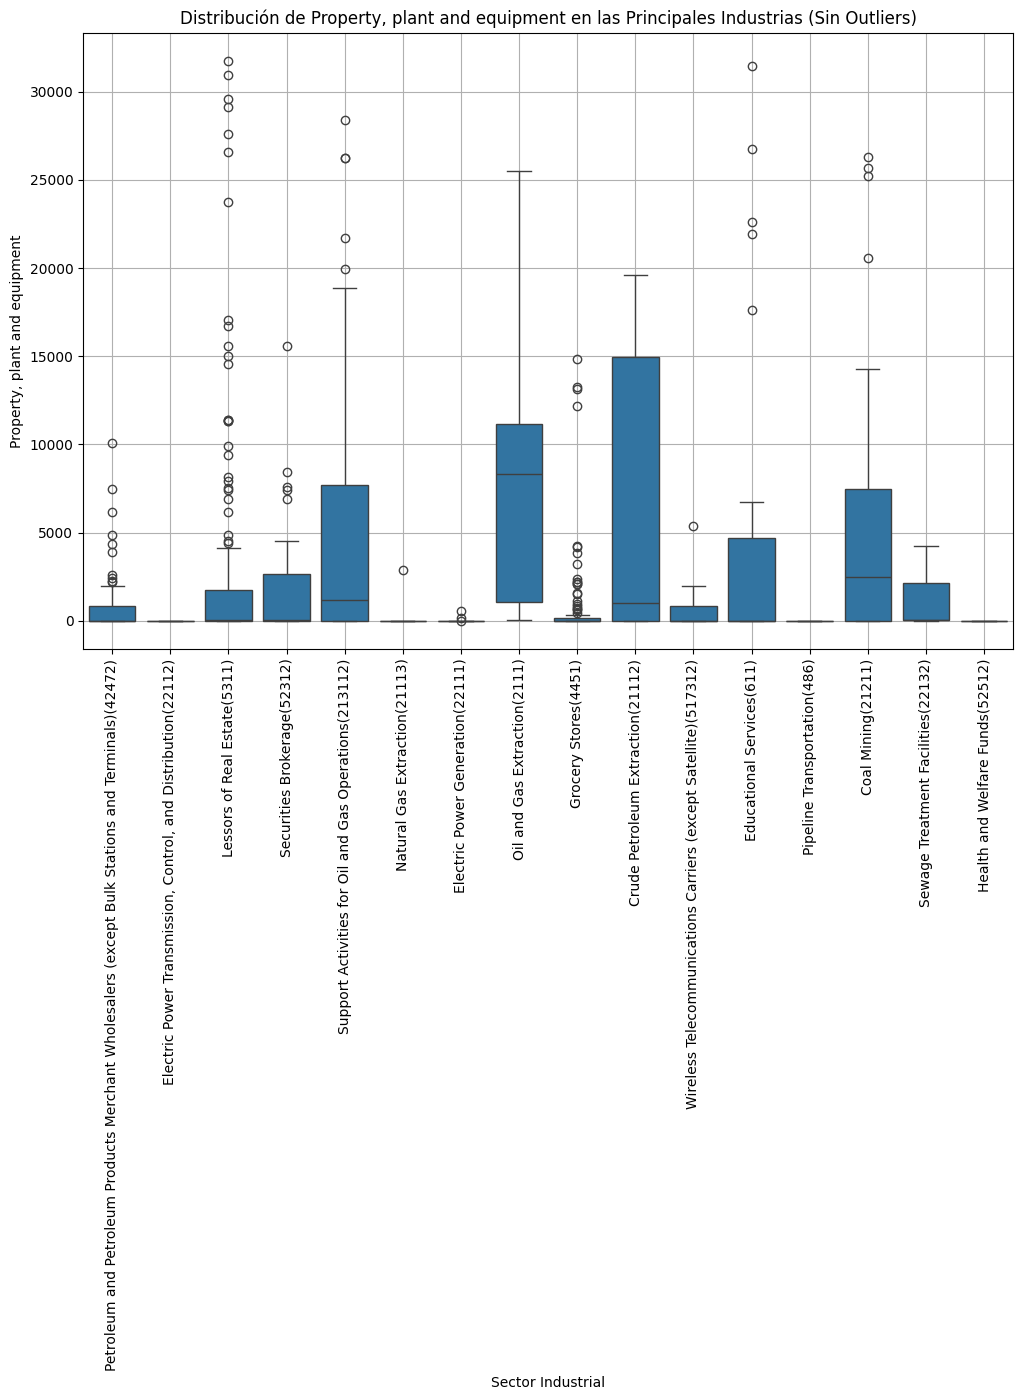

In [80]:
graficar_box_por_industria(datos, "Property, plant and equipment")

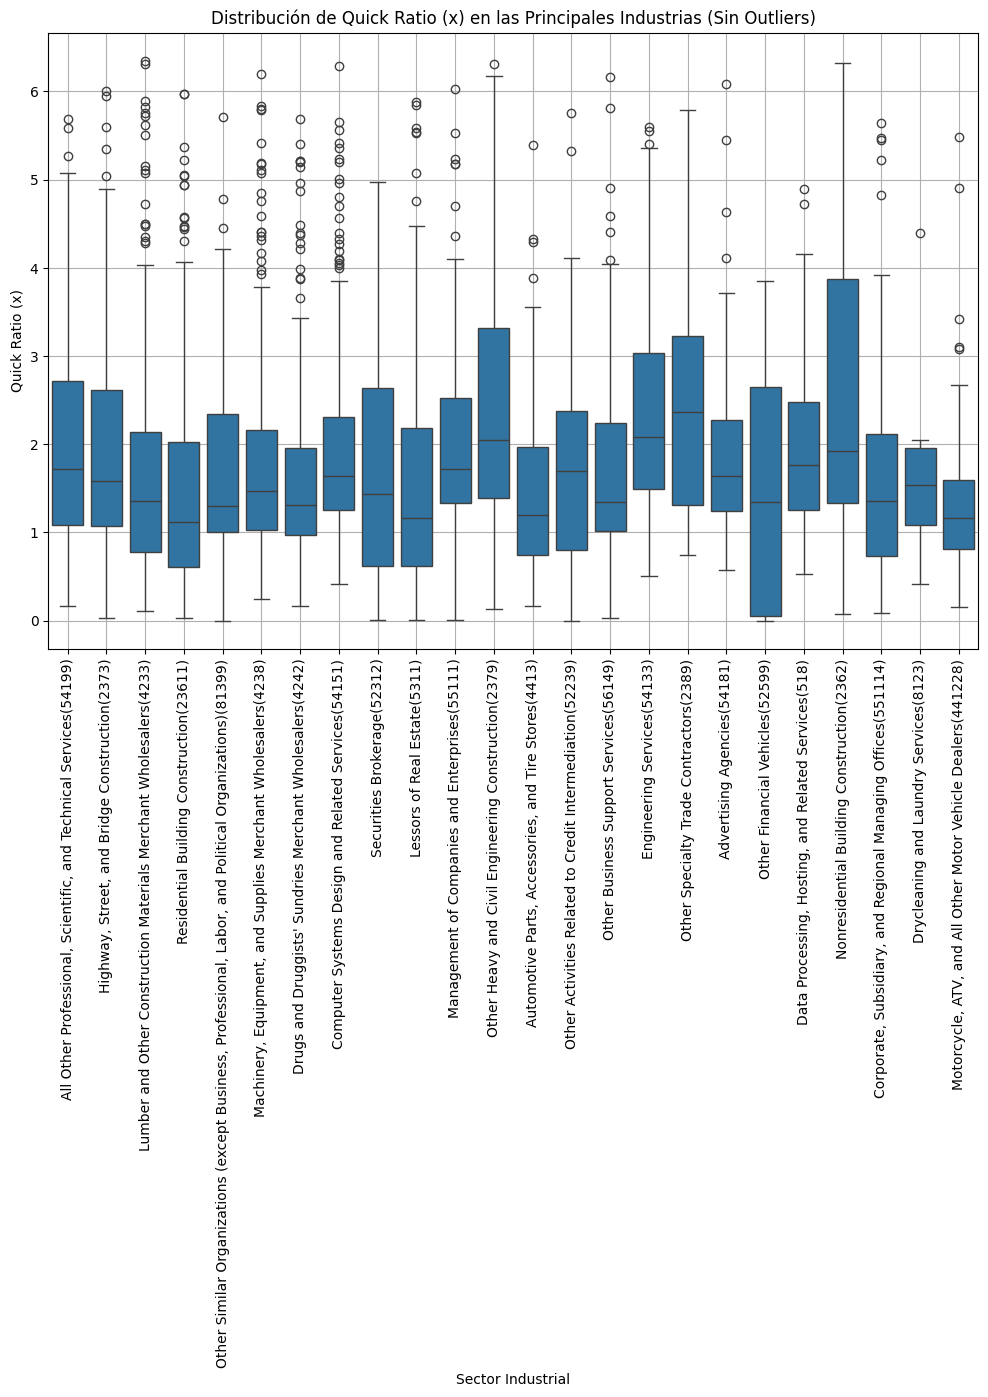

In [81]:
graficar_box_por_industria(datos, "Quick Ratio (x)")

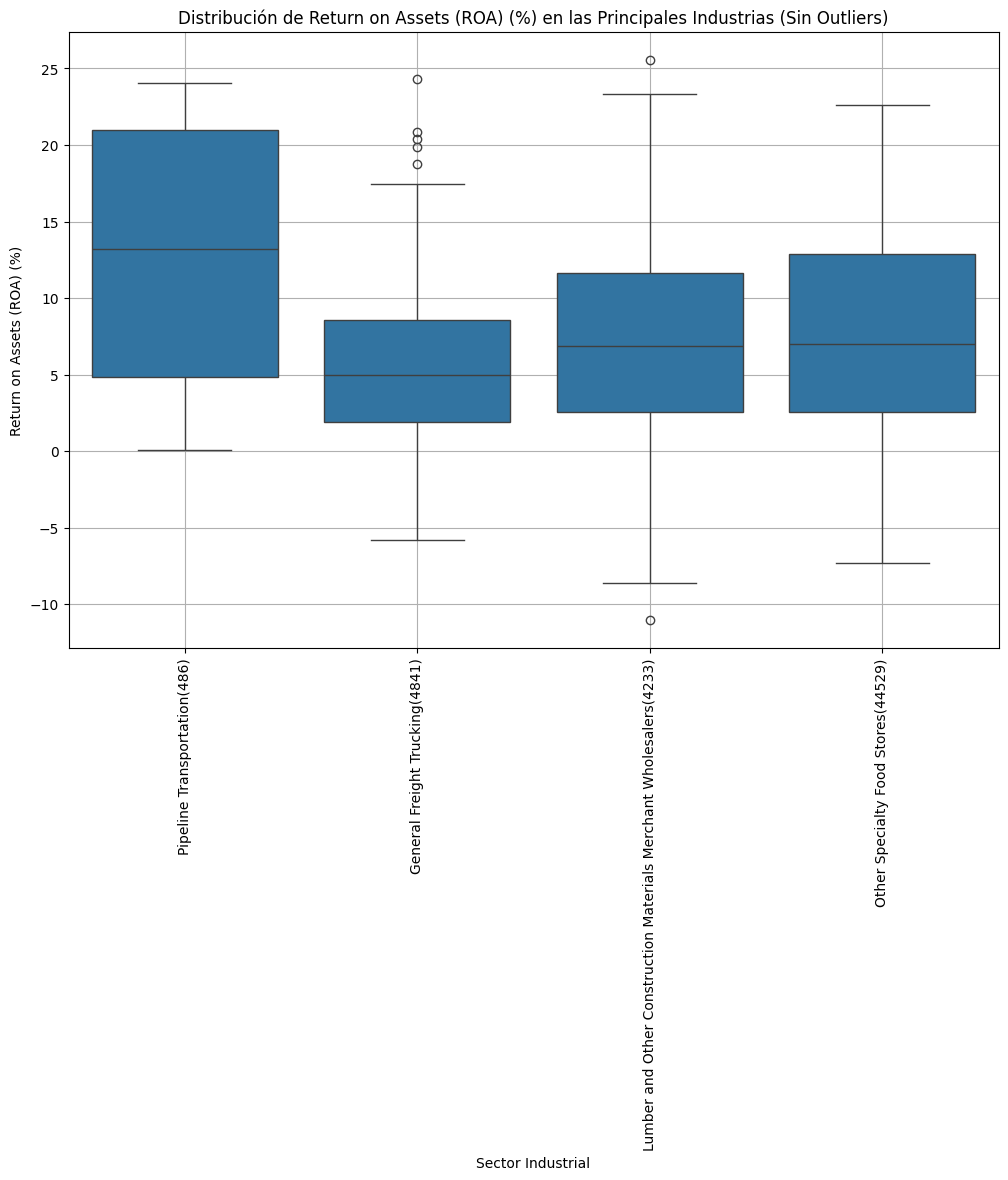

In [82]:
graficar_box_por_industria(datos, "Return on Assets (ROA) (%)")

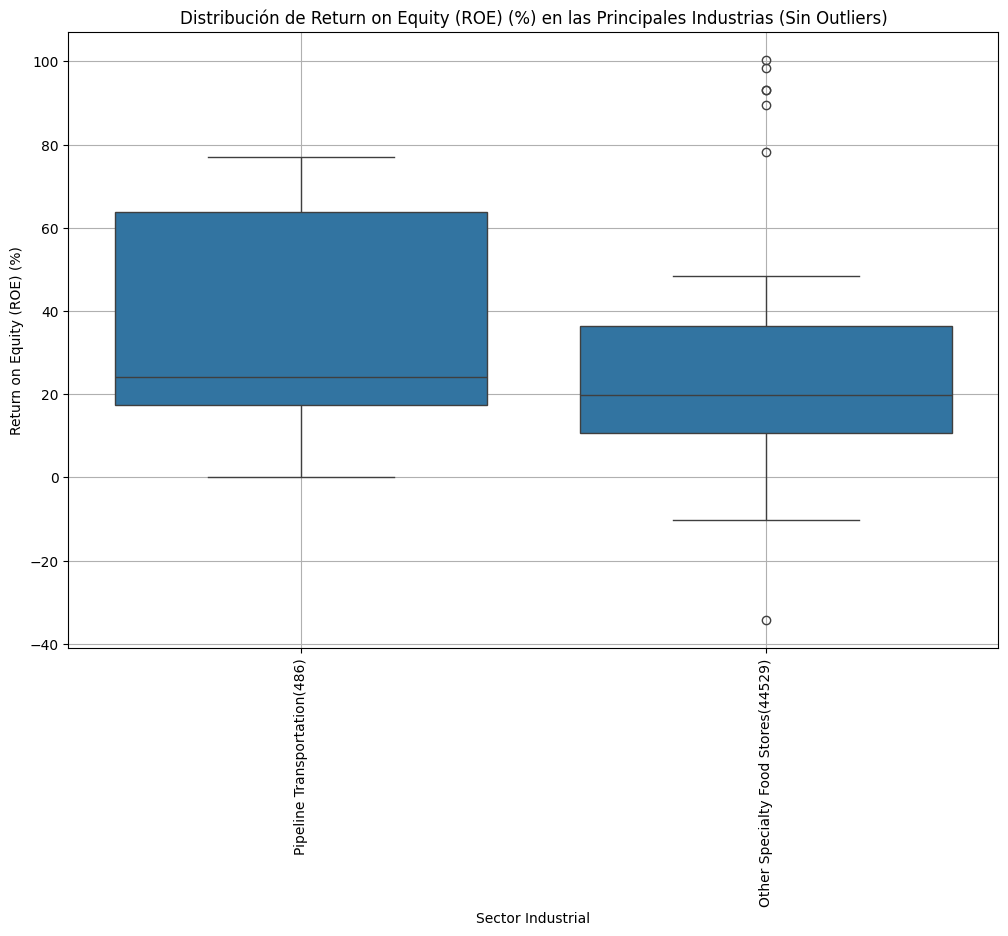

In [83]:
graficar_box_por_industria(datos, "Return on Equity (ROE) (%)")

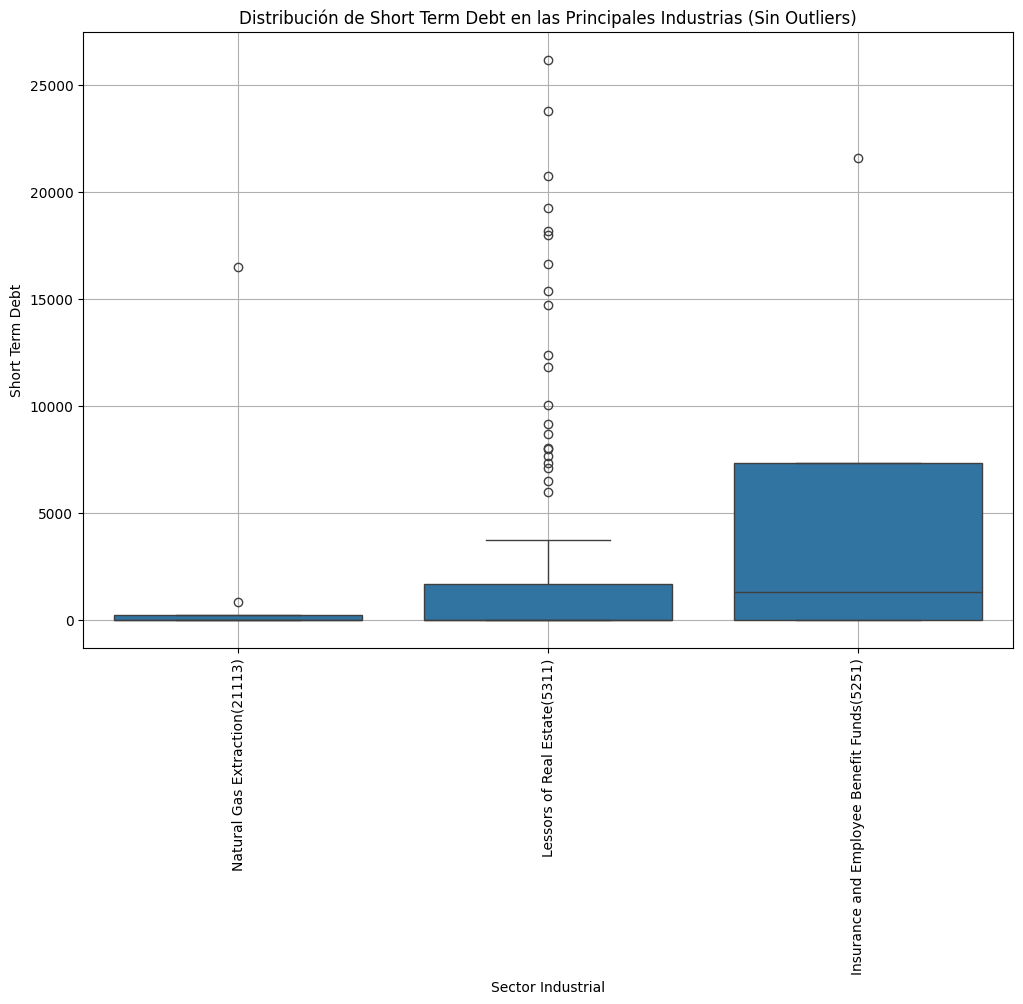

In [84]:
graficar_box_por_industria(datos, "Short Term Debt")

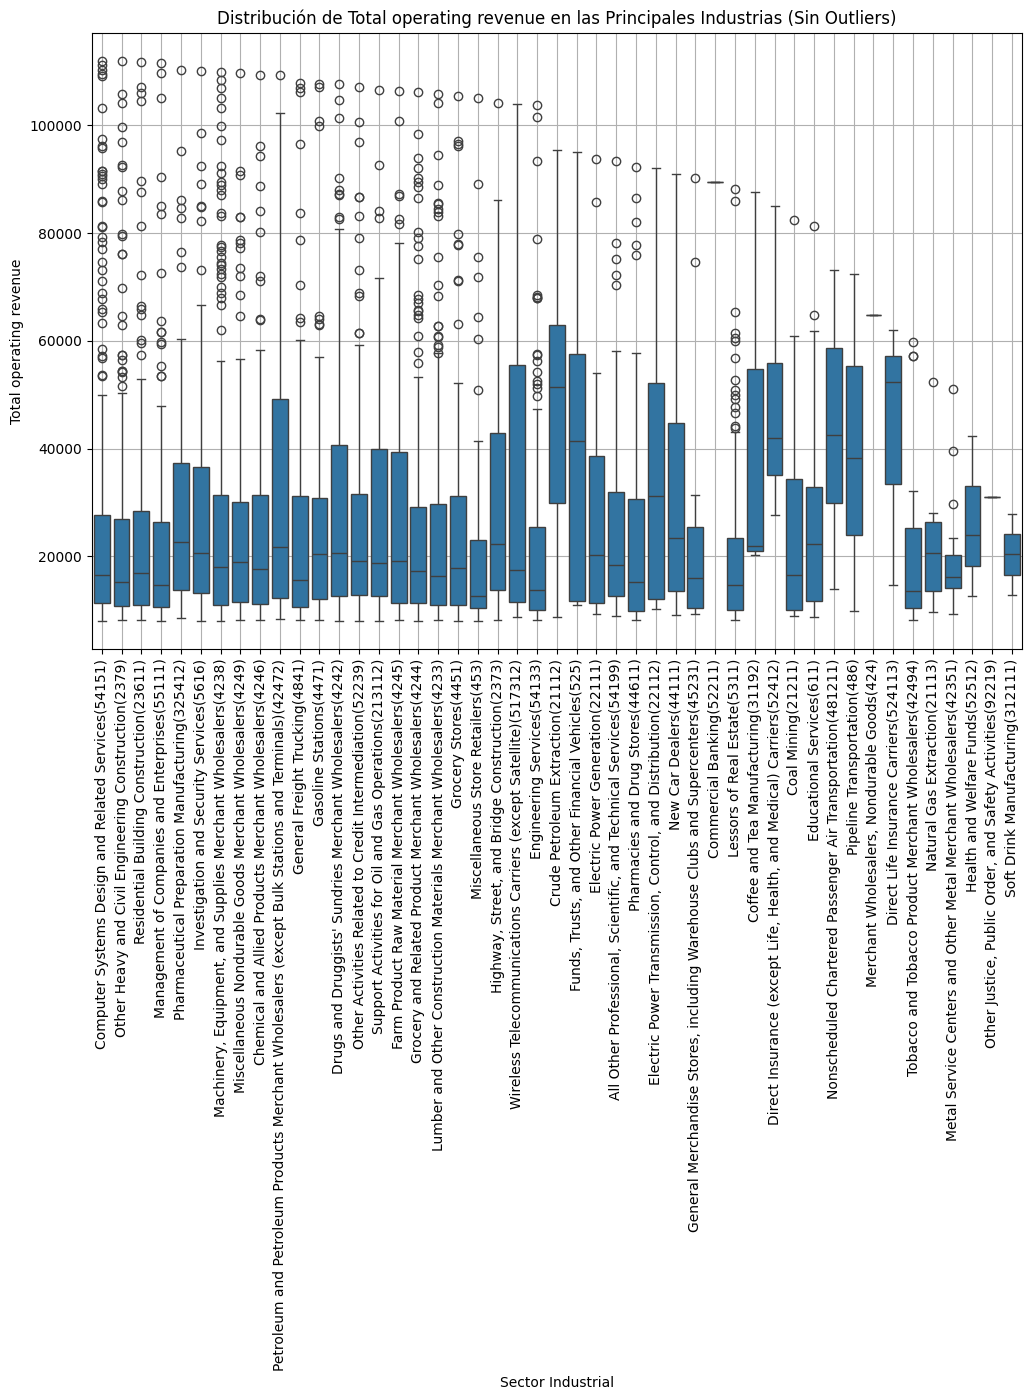

In [85]:
graficar_box_por_industria(datos, "Total operating revenue")

# PCA

In [86]:
# Filtrar las columnas numéricas
numeric_columns = datos.select_dtypes(include=['float64', 'int64']).columns
data_numeric = datos[numeric_columns].dropna(axis=1)


# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Aplicar PCA
pca = PCA(n_components=2)  # Escogemos 2 componentes para visualización
pca_result = pca.fit_transform(data_scaled)

# Mostrar la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

In [87]:
explained_variance

array([0.06061886, 0.05464854])

In [88]:
# Filtrar las columnas numéricas
numeric_columns = datos.select_dtypes(include=['float64', 'int64']).columns
data_numeric = datos[numeric_columns].dropna(axis=0)

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Aplicar PCA para obtener todas las componentes
pca_full = PCA()
pca_full.fit(data_scaled)

# Calcular la varianza acumulada
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Encontrar el número mínimo de componentes que capturan al menos el 60% de la varianza
n_components_60_var = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.60) + 1
print(f"Se necesitan {n_components_60_var} componentes para capturar al menos el 60% de la varianza.")

# Ahora aplicamos PCA con ese número de componentes
pca_final = PCA(n_components=n_components_60_var)
pca_result_final = pca_final.fit_transform(data_scaled)

# Mostrar la varianza explicada por cada componente
explained_variance_final = pca_final.explained_variance_ratio_

# Mostrar la varianza acumulada para el número de componentes necesario
print(f"Varianza explicada acumulada con {n_components_60_var} componentes: {cumulative_variance[n_components_60_var-1]*100:.2f}%")

# Obtener los coeficientes (cargas) de cada componente principal
components = pca_final.components_

# Convertir la matriz de componentes a un DataFrame para una mejor visualización
components_df = pd.DataFrame(components, columns=numeric_columns)

Se necesitan 14 componentes para capturar al menos el 60% de la varianza.
Varianza explicada acumulada con 14 componentes: 60.22%


In [89]:
components_df

Cash and Cash Equivalents  Long term Debt  Net Sales Revenue Trend (%)  \
0                        0.47            0.50                        -0.00   
1                        0.27            0.12                         0.07   
2                       -0.05           -0.01                        -0.03   
3                        0.00            0.00                        -0.14   
4                        0.08            0.02                        -0.12   
5                        0.06            0.01                        -0.21   
6                       -0.00           -0.00                        -0.30   
7                       -0.00           -0.00                        -0.18   
8                       -0.02            0.00                         0.42   
9                        0.01           -0.00                         0.31   
10                      -0.03            0.00                         0.07   
11                       0.05            0.00                         0.05   
12                       0.05           -0.01                         0.00   
13                      -0.02            0.00                         0.05   

    Operating Profit Trend (%)  Property, plant and equipment  \
0                        -0.00                           0.44   
1                         0.03                          -0.30   
2                        -0.06                           0.06   
3                        -0.08                           0.00   
4                        -0.08                          -0.11   
5                        -0.12                          -0.09   
6                        -0.33                          -0.01   
7                        -0.18                           0.01   
8                         0.46                           0.05   
9                         0.26                          -0.03   
10                        0.08                           0.08   
11                        0.20                          -0.08   
12                        0.11                          -0.11   
13                       -0.06                           0.03   

    Return on Assets (ROA) (%)  Return on Equity (ROE) (%)  Quick Ratio (x)  \
0                        -0.00                       -0.00            -0.00   
1                         0.04                       -0.02             0.06   
2                        -0.11                       -0.08             0.02   
3                        -0.11                       -0.02            -0.08   
4                        -0.13                        0.07            -0.05   
5                        -0.13                       -0.00            -0.12   
6                        -0.25                        0.01            -0.09   
7                        -0.01                       -0.02            -0.03   
8                        -0.05                       -0.03             0.03   
9                        -0.25                        0.00             0.06   
10                        0.07                        0.10            -0.05   
11                        0.25                        0.20            -0.10   
12                       -0.01                       -0.36            -0.18   
13                       -0.10                        0.03             0.17   

    Short Term Debt  Total operating revenue  Employees  Export_CN  Import_CN  \
0              0.32                     0.44       0.18       0.02      -0.00   
1              0.56                    -0.33      -0.44      -0.09      -0.03   
2             -0.09                     0.05       0.09       0.27       0.56   
3              0.01                     0.01      -0.06       0.06       0.16   
4              0.18                    -0.11      -0.14      -0.01       0.10   
5              0.14                    -0.08      -0.05      -0.07      -0.05   
6              0.01                    -0.01      -0.02      -0.02      -0.13   
7             -0.01    

- Sobre el componente 0, las variables que más contribuyen a este componente son Long term Debt (0.50), Cash and Cash Equivalents (0.47), Property, plant and equipment (0.44), Property, plant and equipment (0.44), Total operating revenue (0.44) y Short Term Debt (0.32).
- El PC0 refleja una combinación de variables relacionadas con la estructura financiera de las empresas

- Sobre el componente 1, las variables más relevantes son Short Term Debt (0.56) y Employees (-0.44), además de influencias menores de variables como Total operating revenue (-0.33) y Cash and Cash Equivalents (0.27).
- El componente PC1 podría estar capturando la relación entre deuda a corto plazo y las tendencias de las ganancias operativas, lo que sugiere que aquellas empresas con mayores deudas a corto plazo podrían tener un desempeño financiero distinto en términos de crecimiento de ingresos y beneficios.

In [90]:
components_df.to_csv("datos/componentes.csv")